# Seasonal and time series analysis

## Initial setup

### Load modules

In [1]:
# modules in this package
import load_and_preprocess as lp
import analysis as at
import bic_and_aic as ba
import plot_tools as pt
import file_io as io
import numpy as np
import xarray as xr
import density
import gmm
# plotting tools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib as mpl
import cmocean
# os tools
import os.path

# suppress a particular warning
import warnings
warnings.filterwarnings('ignore', 'RuntimeWarning: All-NaN slice encountered')

### Set runtime parameters (file locations, etc.)

In [2]:
# set locations and names
descrip = 'WeddellOnly' # extra description for filename
data_location = '../../so-chic-data/' # input data location
classified_data_location = 'models/profiles_-65to80lon_-85to-30lat_20to1000depth_5K_allDomain_revised.nc'
ploc = 'plots/plots_WeddellClassOnly_top1000m_K04_forPaper/'
#ploc = 'tests/'
dloc = 'models/'

# if plot directory doesn't exist, create it
if not os.path.exists(ploc):
    os.makedirs(ploc)

# save the processed output as a NetCDF file?
saveOutput = False

# number of PCA components (roughly 95%)
n_pca = 6

# make decision about n_components_selected (iterative part of analysis)
n_components_selected = 4

#longitude and latitude range
lon_min = -65
lon_max =  80
lat_min = -80
lat_max = -45
# depth range
zmin = 20.0
zmax = 1000.0
# density range
sig0range = (26.6, 28.0)

# temperature and salinity ranges for plotting
lon_range=(lon_min, lon_max)
lat_range=(lat_min, lat_max)
Trange=(-2.2, 6.0)
Srange=(33.5, 35.0)

# create filename for saving GMM and saving labelled profiles
pca_fname = dloc + 'pca_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_pca)) + descrip
gmm_fname = dloc + 'gmm_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip
fname = dloc + 'profiles_' + str(int(lon_min)) + 'to' + str(int(lon_max)) + 'lon_' + str(int(lat_min)) + 'to' + str(int(lat_max)) + 'lat_' + str(int(zmin)) + 'to' + str(int(zmax)) + 'depth_' + str(int(n_components_selected)) + 'K_' + descrip + '.nc'

# colormap
colormap = plt.get_cmap('Dark2', n_components_selected)
colormap_cividis = plt.get_cmap('cividis', 20)

### Load classified profile data

In [3]:
dfp = xr.open_dataset("weddell_classified_n4.nc")
# select the top pressure level for plotting purposes
df1D = dfp.isel(depth=0)

## Map out individual seasons

Helper function to add season as a coordinate

In [4]:
def add_season_coordinate(dfp):
    
    import xarray as xr
    
    nsize = dfp.profile.size
    month = dfp.month.values
    season = np.zeros((nsize,), dtype='int')
    
    # assign season based on the month (1=DJF, 2=MAM, 3=JJA, 4=SON)
    for i in range(nsize):
        if (month[i]==12 or month[i]==1 or month[i]==2):
            season[i] = 1
        elif (month[i]==3 or month[i]==4 or month[i]==5):
            season[i] = 2
        elif (month[i]==6 or month[i]==7 or month[i]==8):
            season[i] = 3
        elif (month[i]==9 or month[i]==10 or month[i]==11):
            season[i] = 4
        else:
            season[i] = None

    # add season to DataArray
    dseason = xr.DataArray(season, dims=['profile'])
    dfp['season'] = dseason
    dfp = dfp.set_coords({'season'})
    
    return dfp

In [5]:
dfp = add_season_coordinate(dfp)
dfp

<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, CLASS: 4, depth_mid: 20)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 ...
    lat            (profile) float64 ...
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] ...
    year           (profile) int64 ...
    month          (profile) int64 1 1 1 1 1 1 1 1 1 1 ... 8 8 8 9 9 9 9 9 10 10
  * CLASS          (CLASS) int64 0 1 2 3
  * depth_mid      (depth_mid) float64 30.0 50.0 70.0 90.0 ... 775.0 865.0 955.0
    season         (profile) int64 1 1 1 1 1 1 1 1 1 1 1 ... 3 3 3 4 4 4 4 4 4 4
Data variables: (12/22)
    prof_date      (profile) float64 ...
    prof_YYYYMMDD  (profile) float64 ...
    prof_HHMMSS    (profile) float64 ...
    sig0           (profile, depth) float64 ...
    prof_SA        (profile, depth) float64 ...
    prof_CT        (profile, depth) float64 ...
    ...             ...
    Smin_depth     (profile) float64 ...
    Smax           (profile) float64 ...
    Smax_depth     (profile) float64 ...
    sig0min        (profile) float64 ...
    sig0max        (profile) float64 ...
    imetric        (profile) float64 ...

plot_tools.plot_hist_map
file_io.load_bathymetry


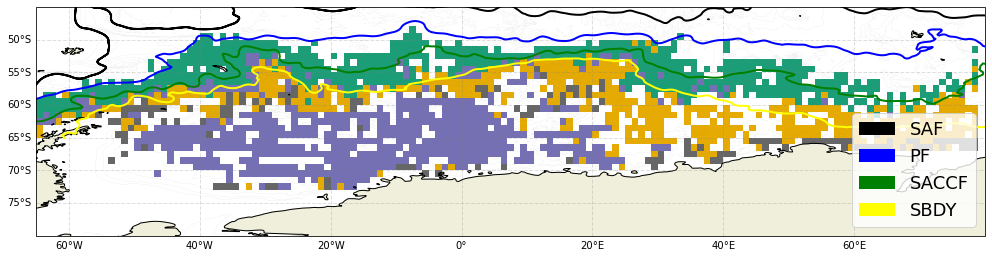

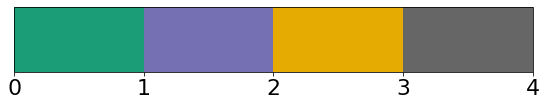

In [6]:
pt.plot_hist_map(ploc, dfp.where(dfp.season==1, drop=True),
                 lon_range, lat_range,
                 n_components_selected,
                 c_range=[0,4],
                 vartype='label',
                 colormap=colormap,
                 moreText='DJF')

plot_tools.plot_hist_map
file_io.load_bathymetry


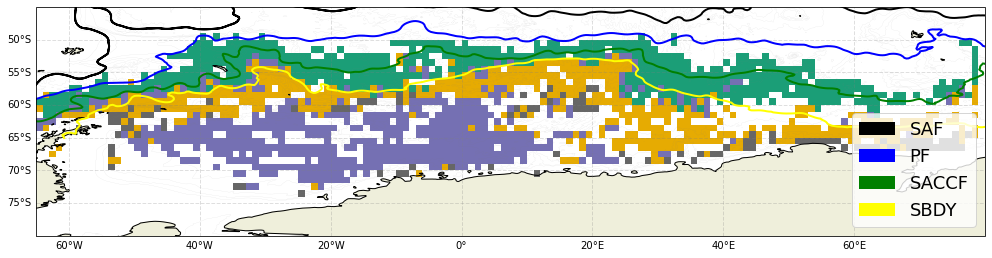

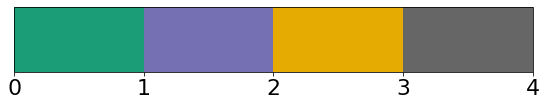

In [7]:
pt.plot_hist_map(ploc, dfp.where(dfp.season==2, drop=True),
                 lon_range, lat_range,
                 n_components_selected,
                 c_range=[0,4],
                 vartype='label',
                 colormap=colormap,
                 moreText='MAM')

plot_tools.plot_hist_map
file_io.load_bathymetry


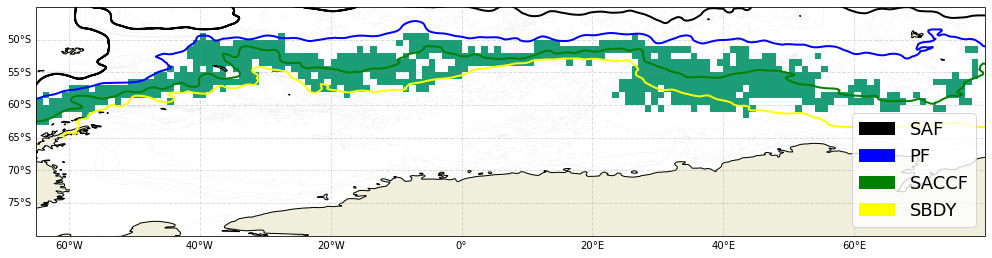

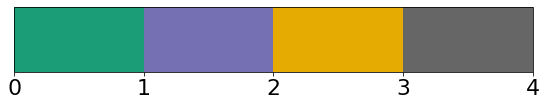

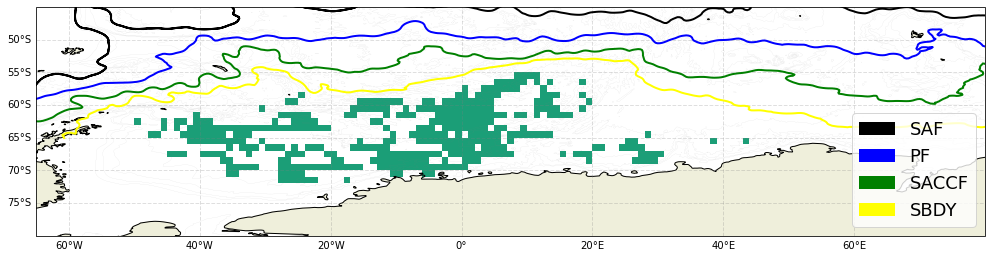

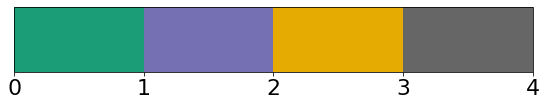

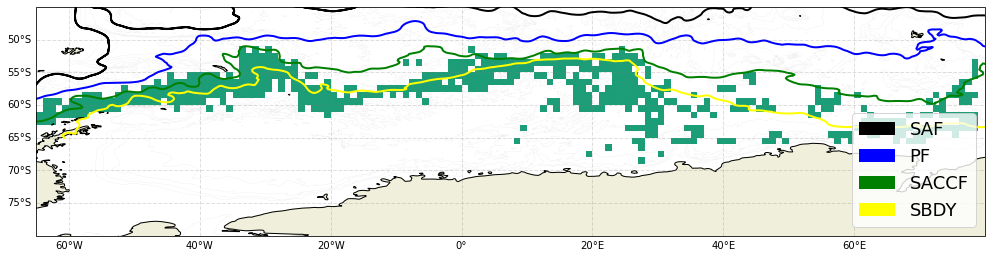

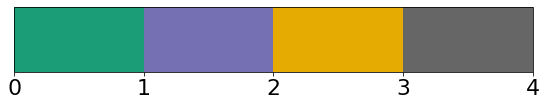

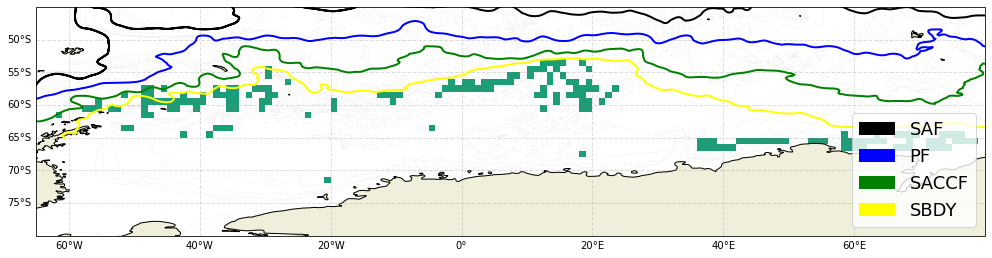

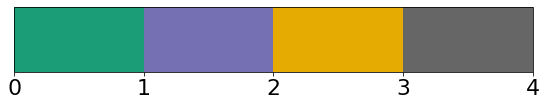

In [8]:
pt.plot_hist_map(ploc, dfp.where(dfp.season==3, drop=True),
                 lon_range, lat_range,
                 n_components_selected,
                 c_range=[0,4],
                 colormap=colormap,
                 moreText='JJA')

plot_tools.plot_hist_map
file_io.load_bathymetry


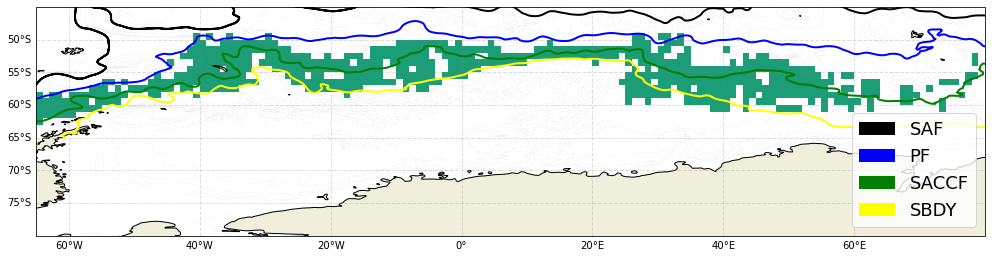

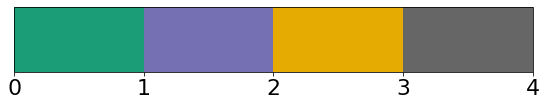

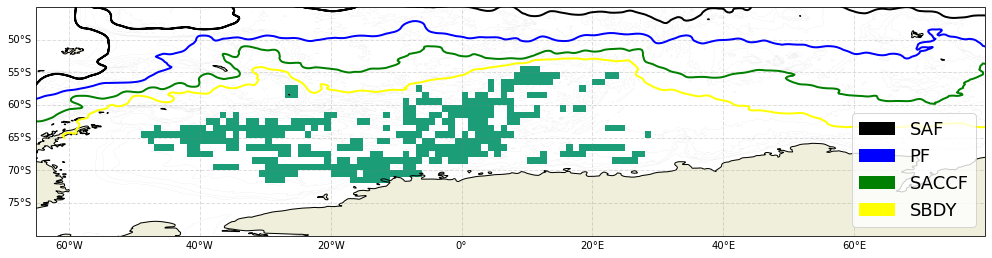

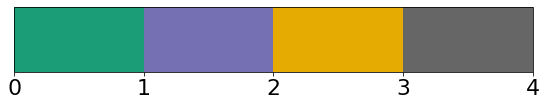

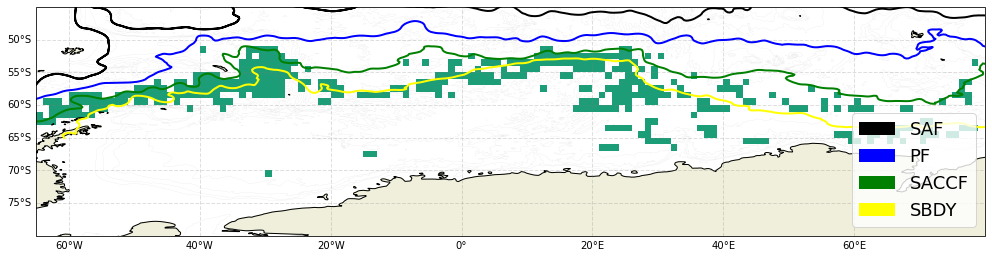

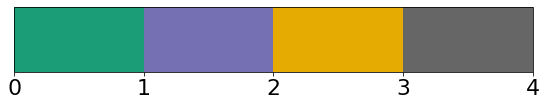

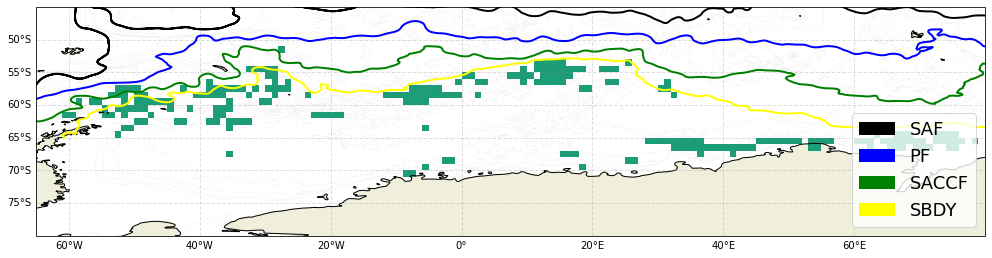

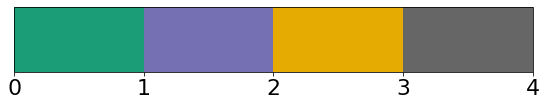

In [9]:
pt.plot_hist_map(ploc, dfp.where(dfp.season==4, drop=True),
                 lon_range, lat_range,
                 n_components_selected,
                 c_range=[0,4],
                 colormap=colormap,
                 moreText='SON')

## T-S histograms by season

# DJF

plot_tools.plot_hist_map


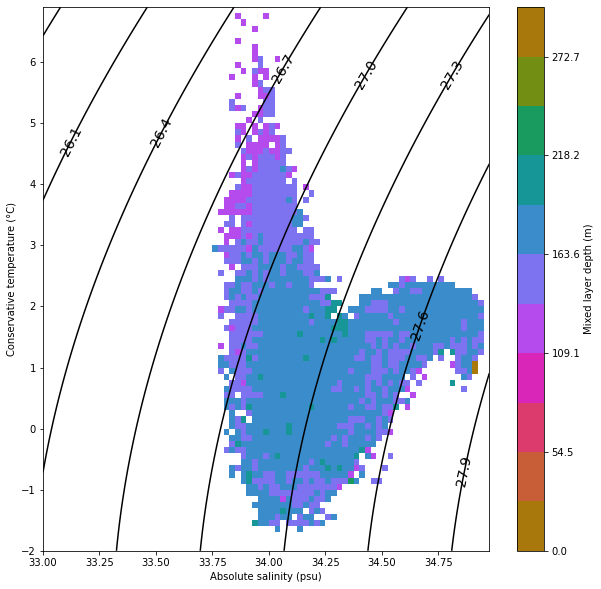

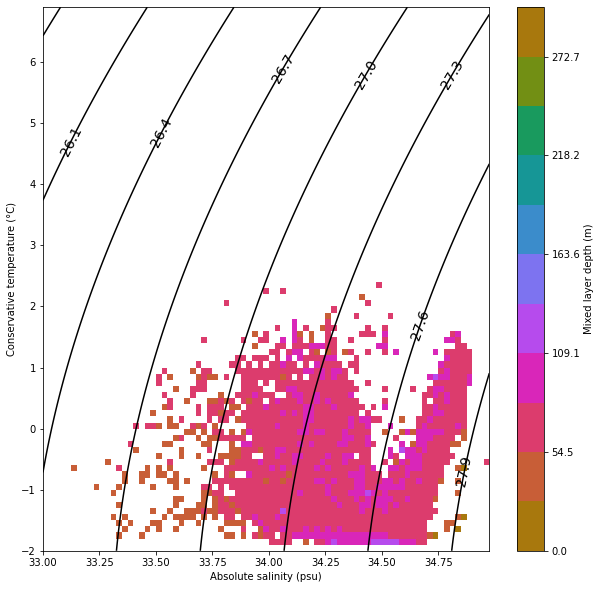

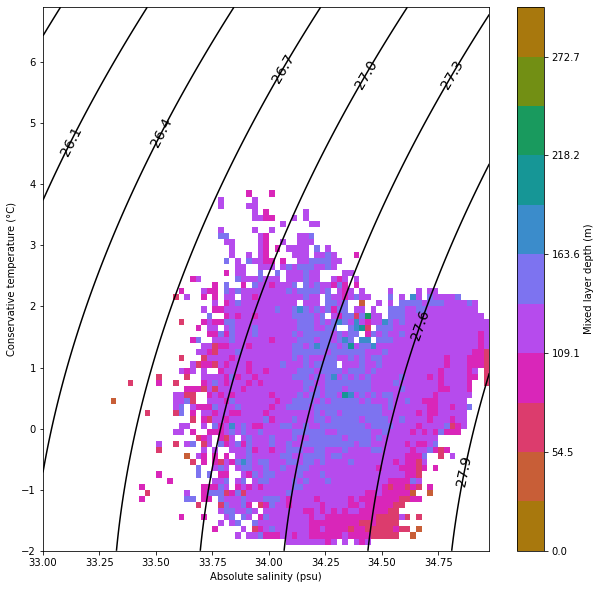

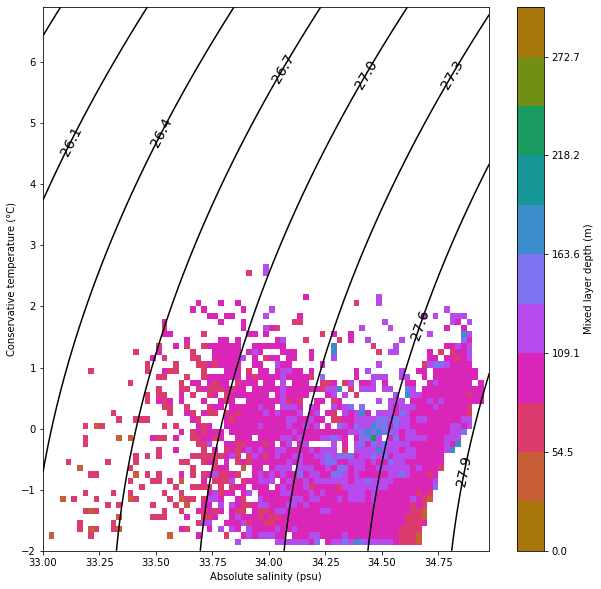

In [10]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==1, drop=True), n_components_selected,
                sbins = np.arange(33, 35, 0.025), 
                tbins = np.arange(-2, 7, 0.1),
                crange=[0,300],
                vartype='mld',
                colormap=cmocean.cm.phase,
                moreText='DJF')

### T-S MLD MAM

plot_tools.plot_hist_map


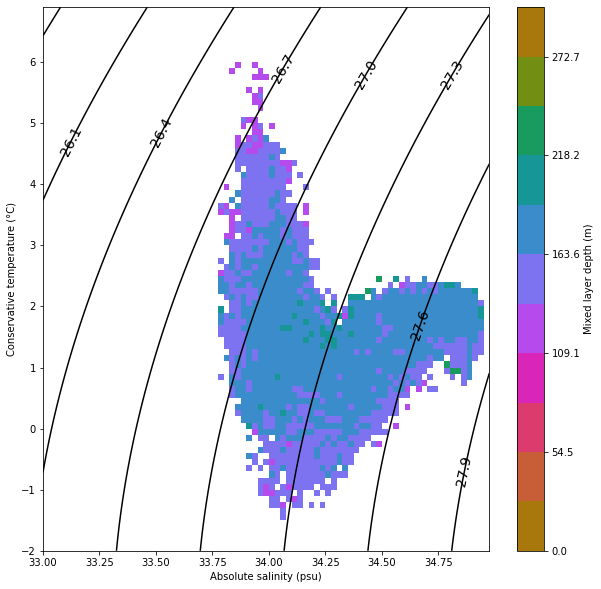

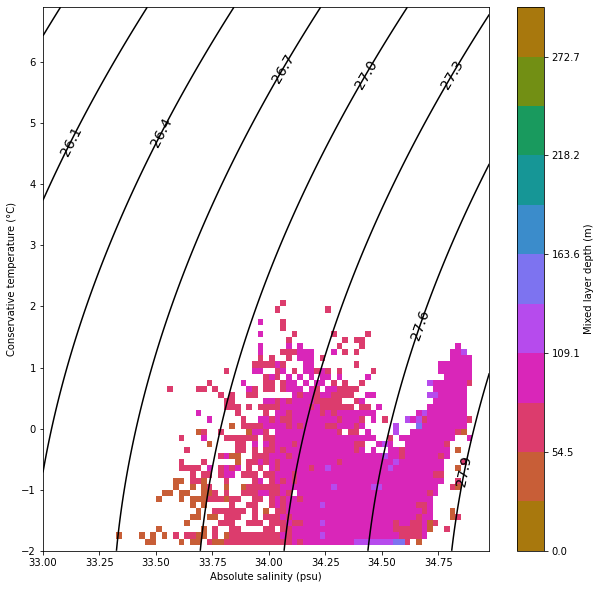

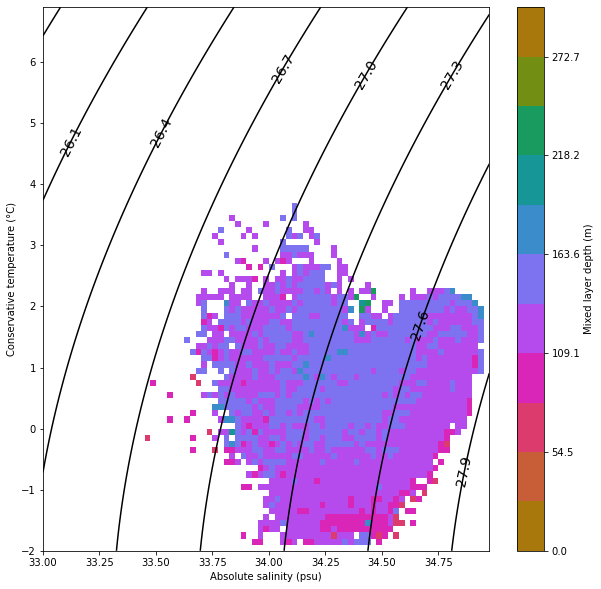

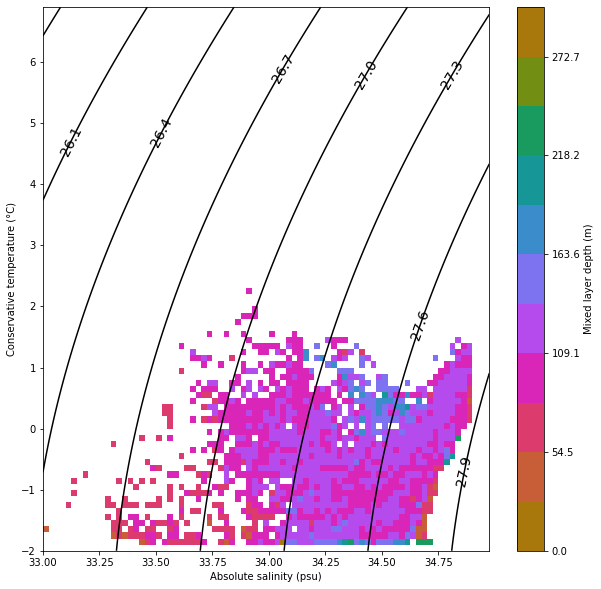

In [11]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==2, drop=True), n_components_selected,
                sbins = np.arange(33, 35, 0.025), 
                tbins = np.arange(-2, 7, 0.1),
                crange=[0,300],
                vartype='mld',
                colormap=cmocean.cm.phase,
                moreText='MAM')

## T-S MLD JJA

plot_tools.plot_hist_map


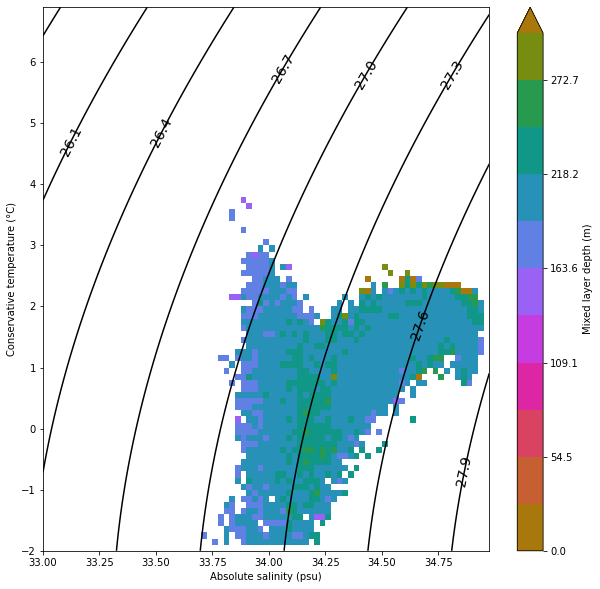

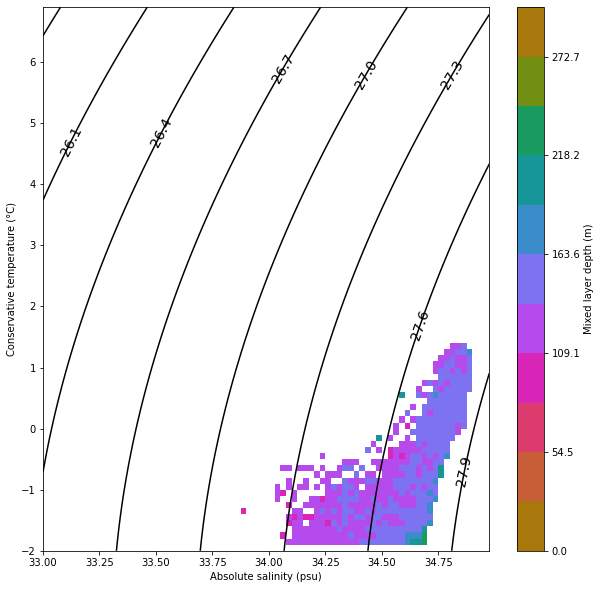

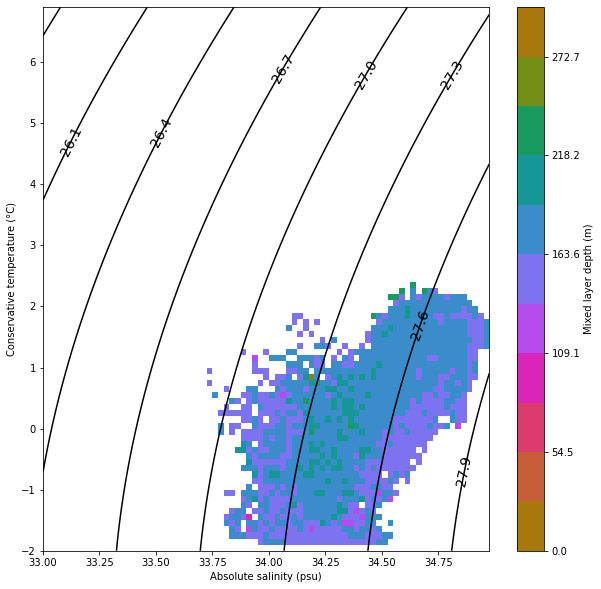

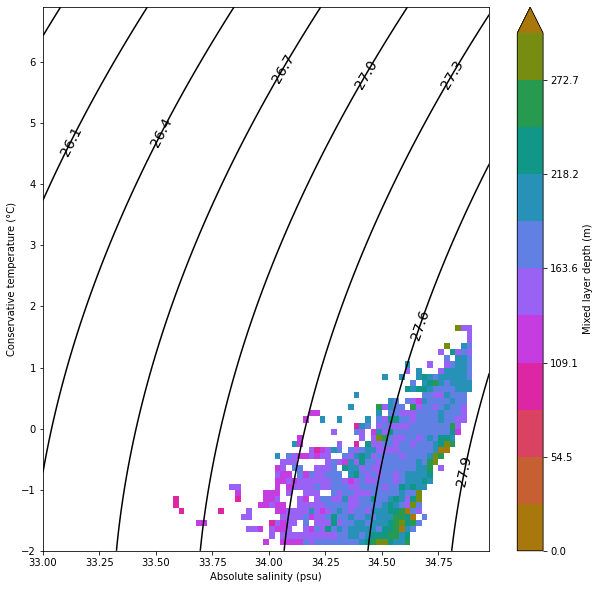

In [12]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==3, drop=True), n_components_selected,
                sbins = np.arange(33, 35, 0.025), 
                tbins = np.arange(-2, 7, 0.1),
                crange=[0,300],
                vartype='mld',
                colormap=cmocean.cm.phase,
                moreText='JJA')

## T-S MLD SON

plot_tools.plot_hist_map


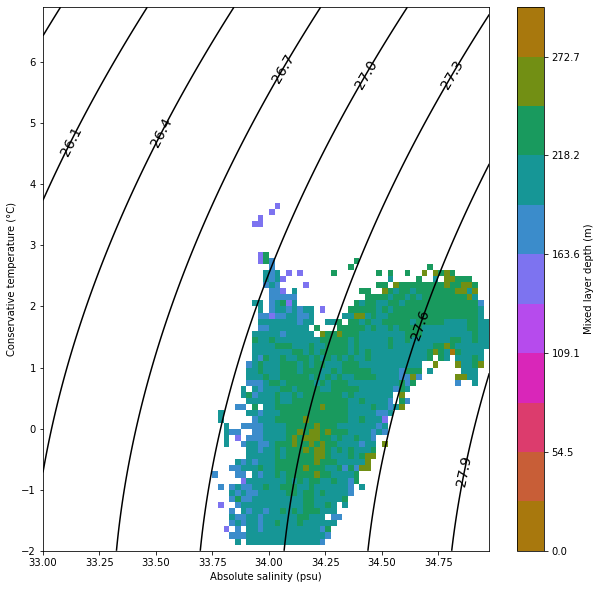

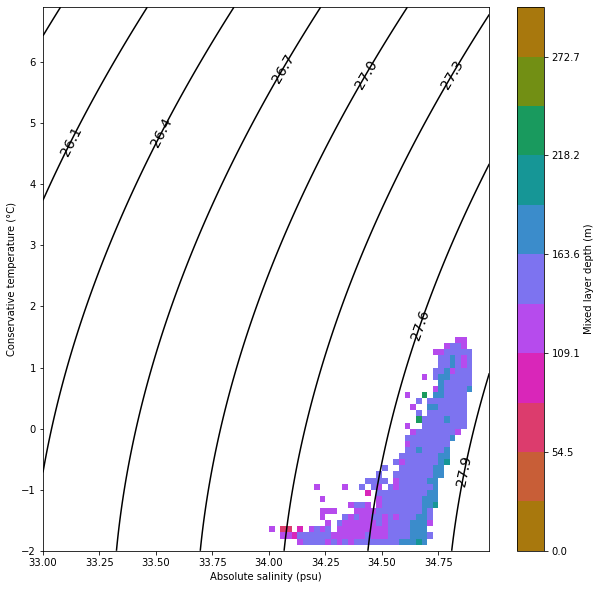

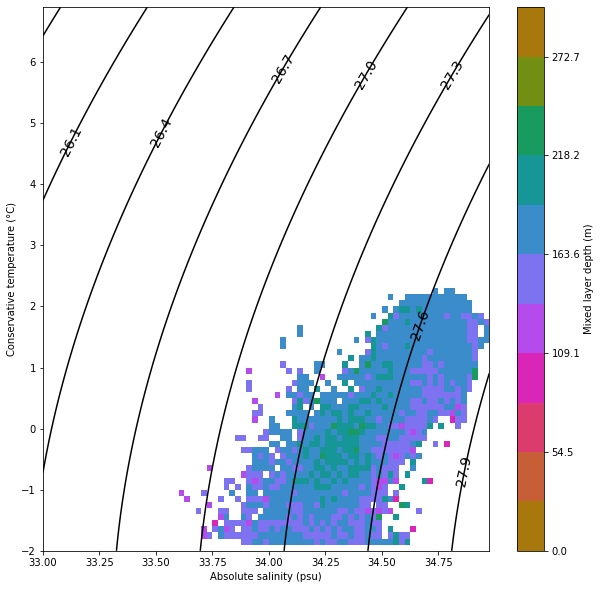

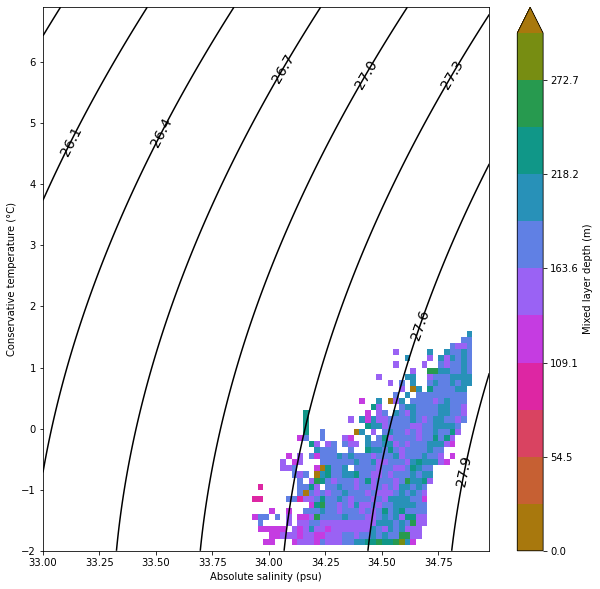

In [13]:
pt.plot_hist_TS(ploc, dfp.where(dfp.season==4, drop=True), n_components_selected,
                sbins = np.arange(33, 35, 0.025), 
                tbins = np.arange(-2, 7, 0.1),
                crange=[0,300],
                vartype='mld',
                colormap=cmocean.cm.phase,
                moreText='SON')

## Profile stats by class and season

### DJF

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


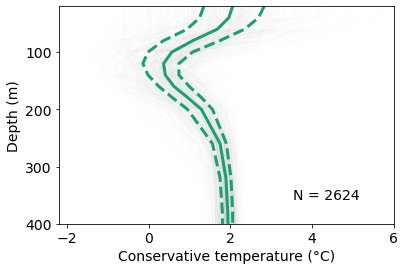

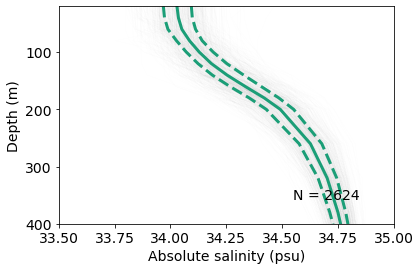

plot_tools.plot_many_profiles


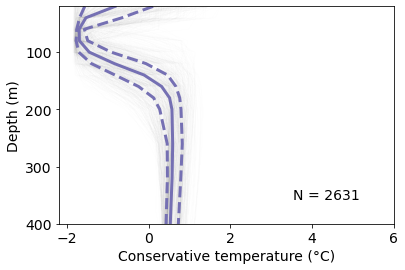

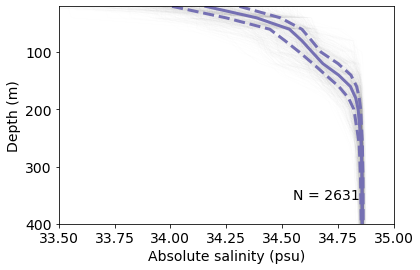

plot_tools.plot_many_profiles


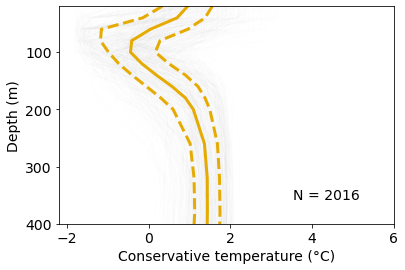

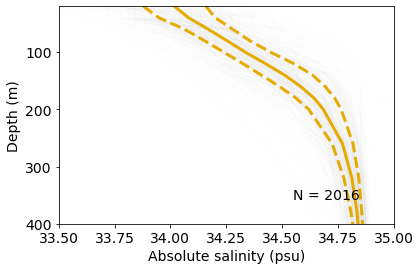

plot_tools.plot_many_profiles


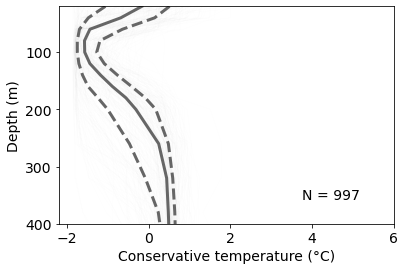

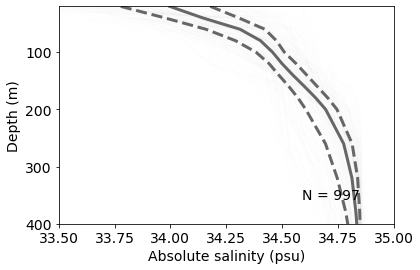

In [14]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==1, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='DJF',
                                  withDensity=False)

### MAM

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


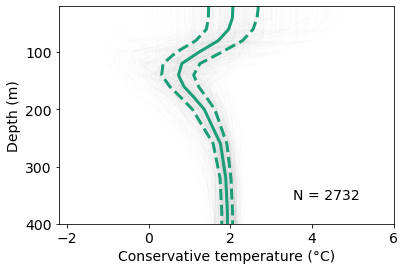

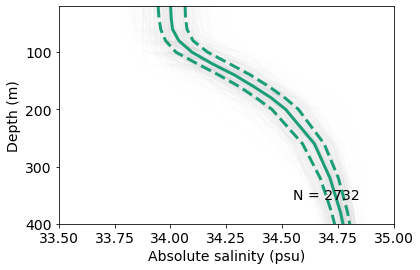

plot_tools.plot_many_profiles


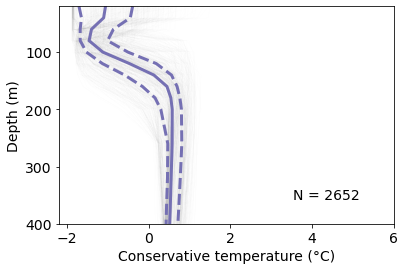

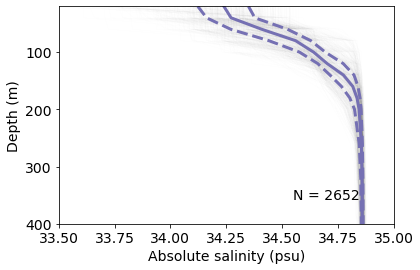

plot_tools.plot_many_profiles


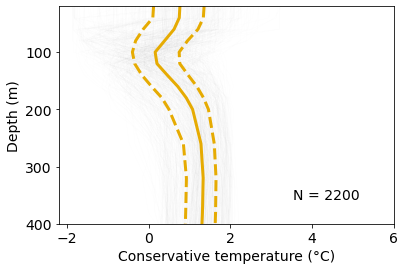

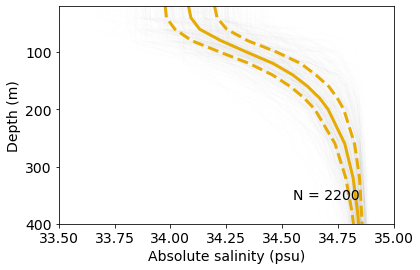

plot_tools.plot_many_profiles


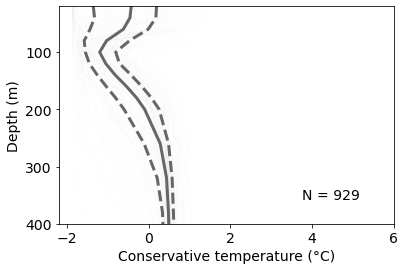

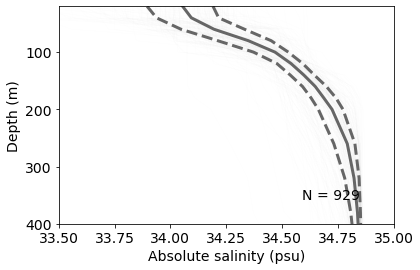

In [15]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==2, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='MAM',
                                  withDensity=False)

### JJA

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


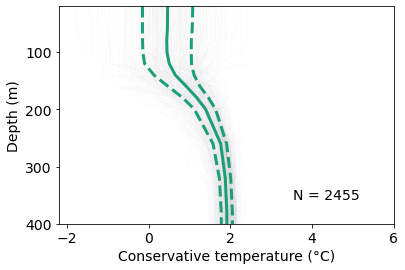

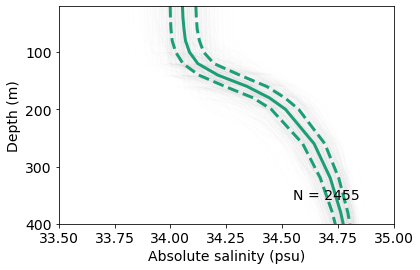

plot_tools.plot_many_profiles


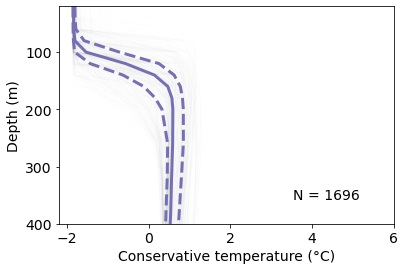

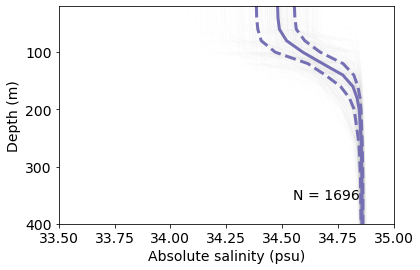

plot_tools.plot_many_profiles


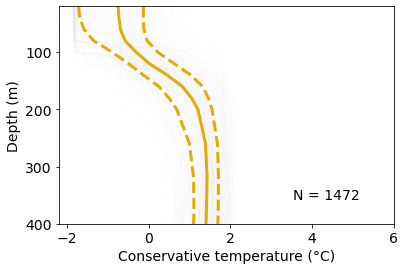

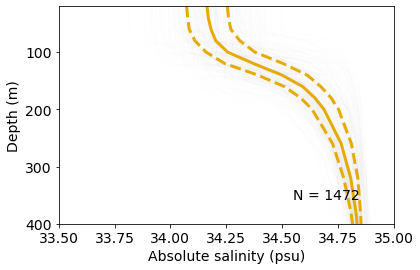

plot_tools.plot_many_profiles


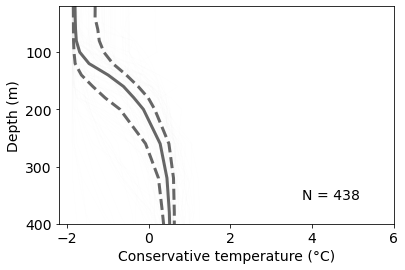

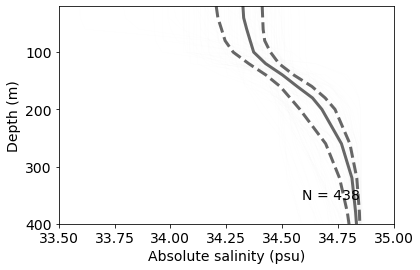

In [16]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==3, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='JJA',
                                  withDensity=False)

### SON

plot_tools.plot_class_vertical_structures
plot_tools.plot_many_profiles


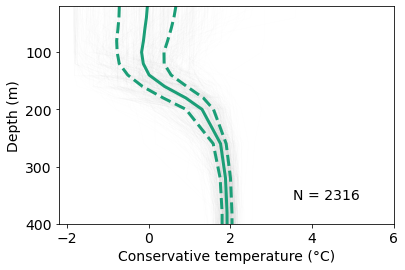

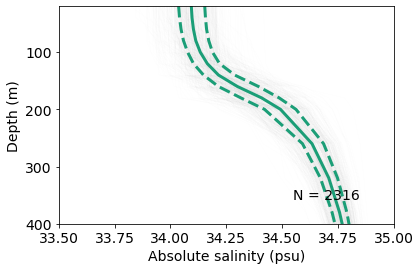

plot_tools.plot_many_profiles


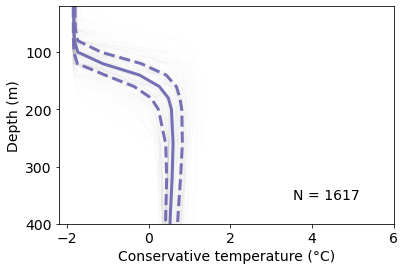

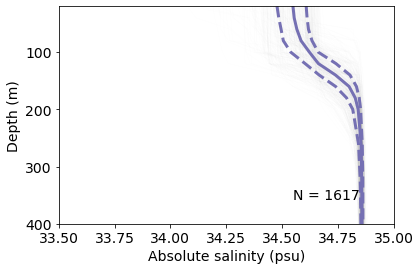

plot_tools.plot_many_profiles


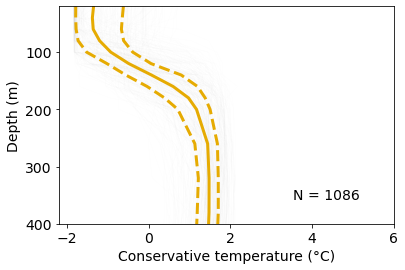

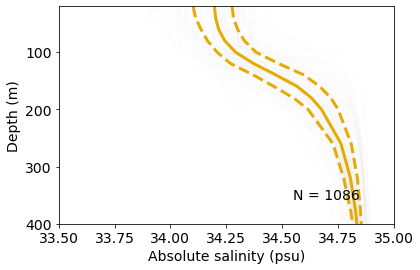

plot_tools.plot_many_profiles


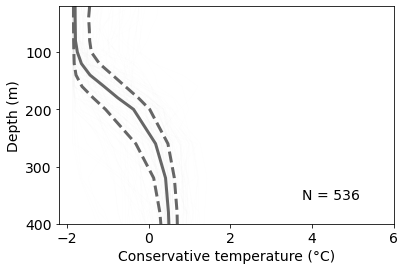

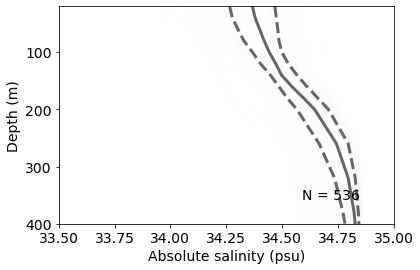

In [17]:
# plot T, S vertical structure of the classes
pt.plot_class_vertical_structures(ploc, dfp.where(dfp.season==4, drop=True), 
                                  n_components_selected, 
                                  colormap,
                                  zmin=zmin, 
                                  zmax=400,
                                  Tmin=Trange[0], 
                                  Tmax=Trange[1],
                                  Smin=Srange[0], 
                                  Smax=Srange[1],
                                  frac=0.25, 
                                  description='SON',
                                  withDensity=False)

## Calculate statistics over time 

### Tmax

analysis.calculate_stats_over_time


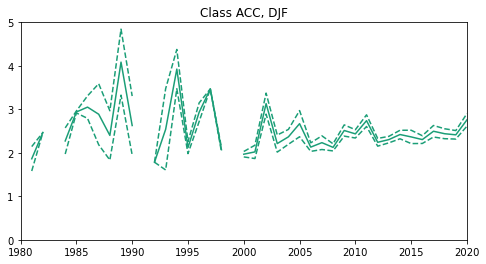

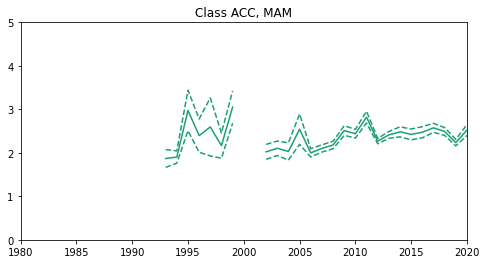

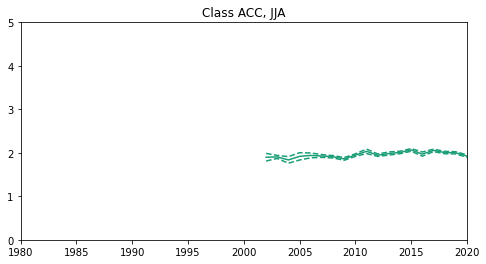

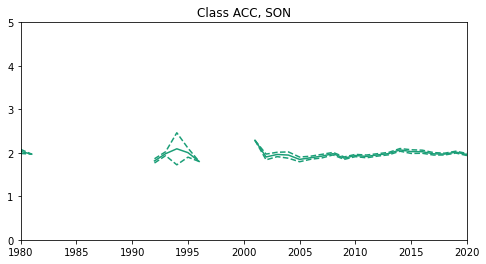

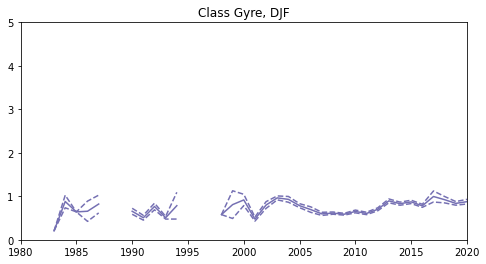

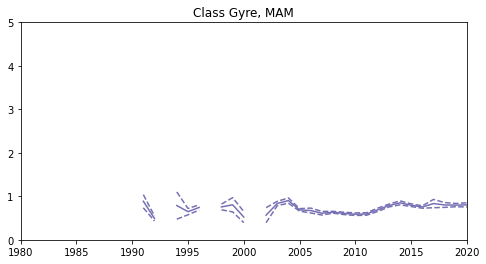

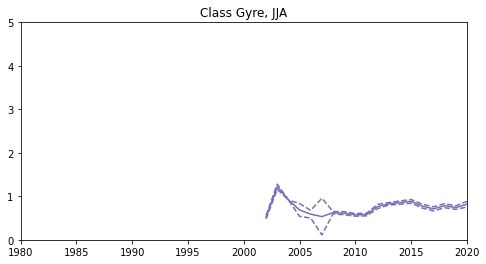

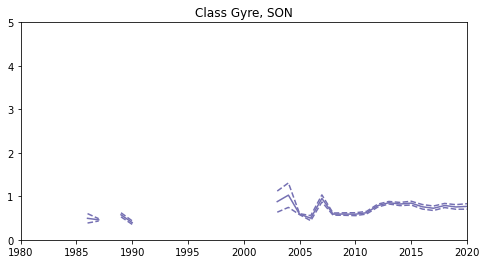

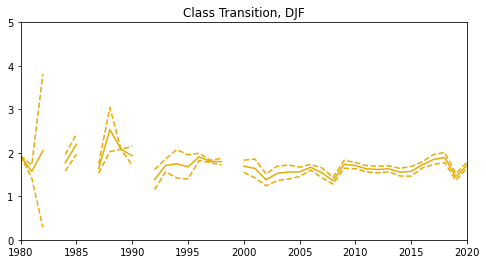

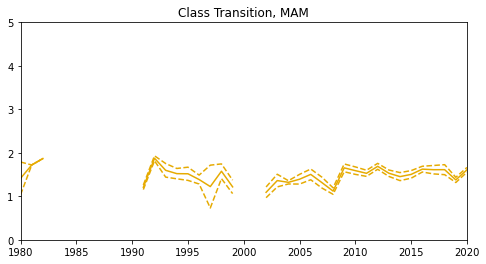

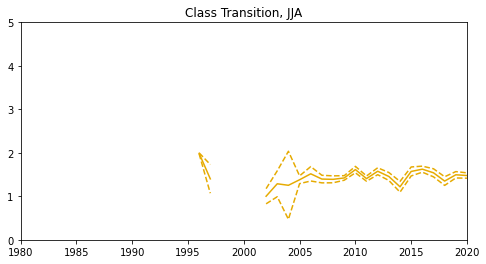

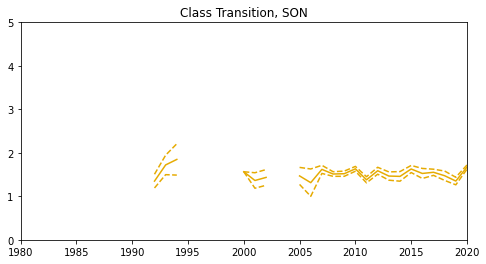

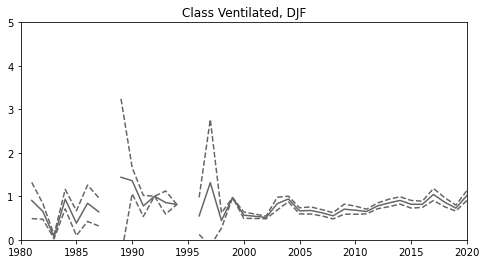

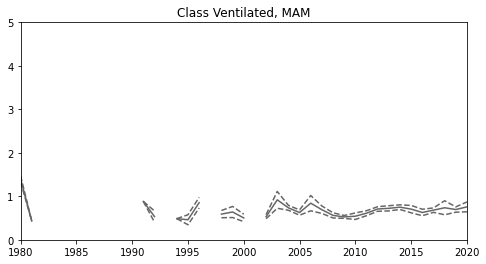

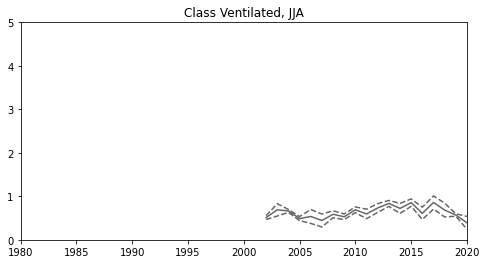

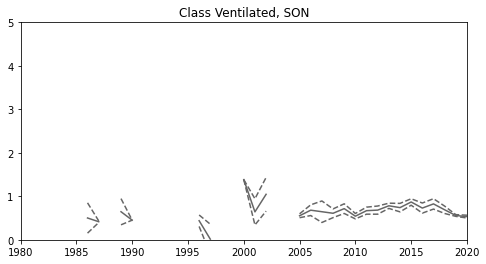

In [18]:
Tmax_mean, Tmax_std, Tmax_N = at.calculate_stats_over_time(dfp, varName='Tmax')
pt.plot_stats_from_analysis(ploc, dfp, Tmax_mean, Tmax_std, Tmax_N, colormap, n_components_selected, varName='Tmax', xlim=[1980, 2020], ylim=[0.0, 5.0])

### Tmin

analysis.calculate_stats_over_time


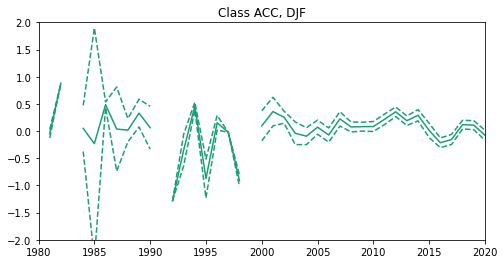

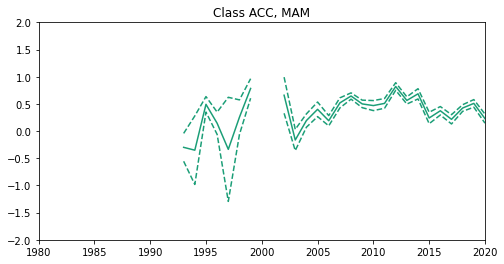

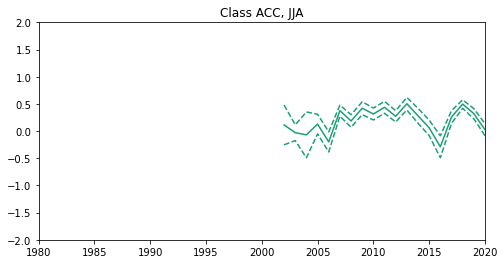

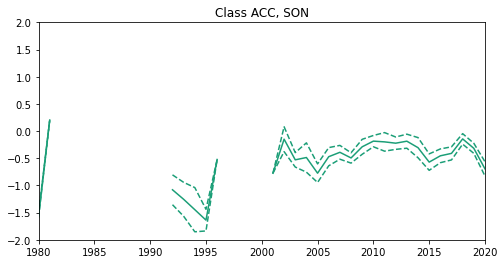

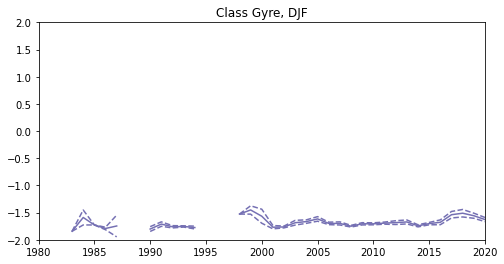

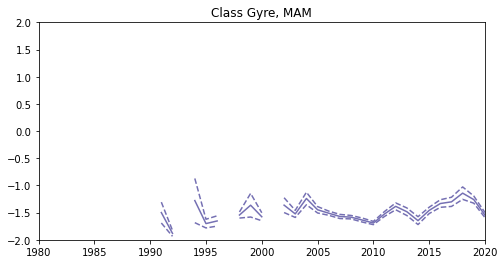

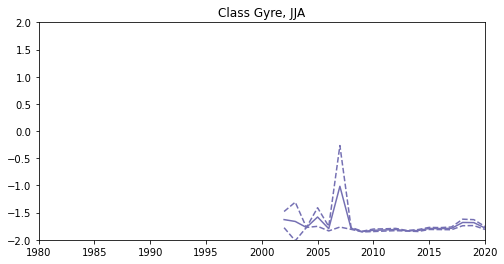

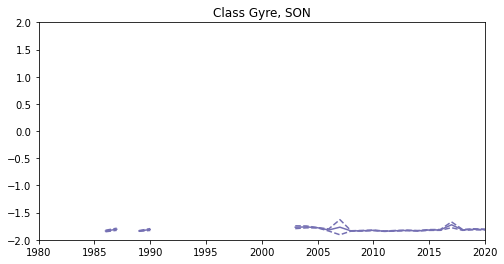

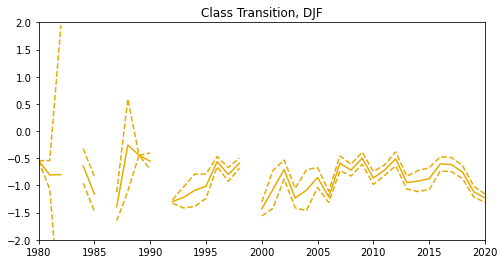

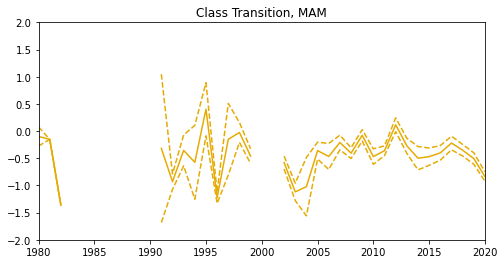

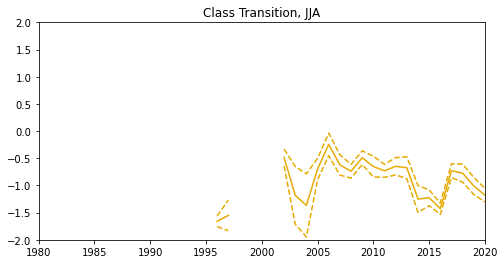

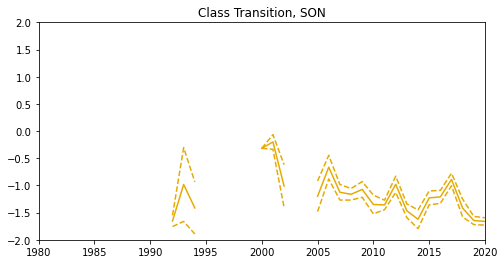

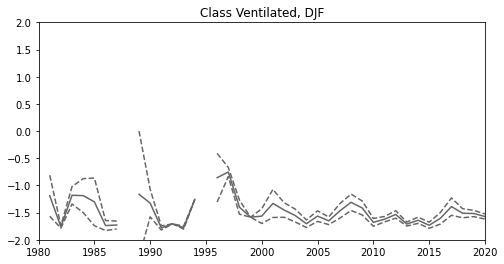

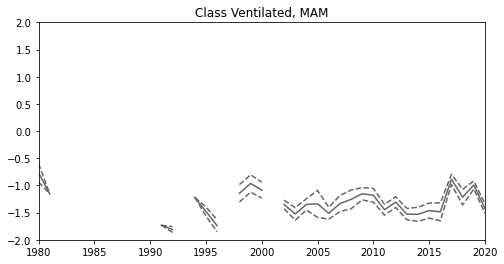

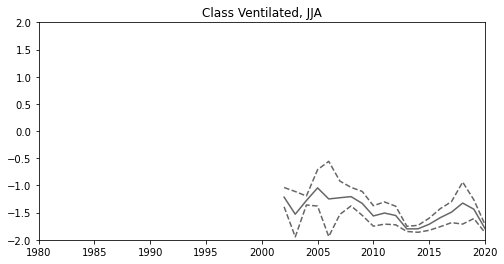

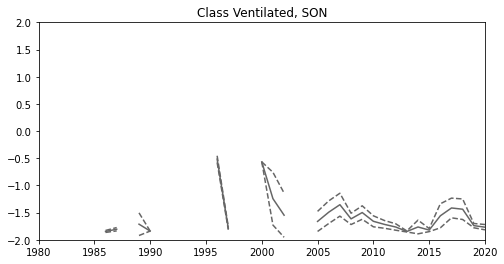

In [19]:
Tmin_mean, Tmin_std, Tmin_N = at.calculate_stats_over_time(dfp, varName='Tmin')
pt.plot_stats_from_analysis(ploc, dfp, Tmin_mean, Tmin_std, Tmin_N, colormap, n_components_selected, varName='Tmin', xlim=[1980, 2020], ylim=[-2.0, 2.0])

### Smax

analysis.calculate_stats_over_time


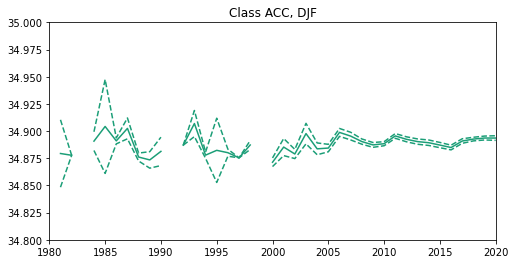

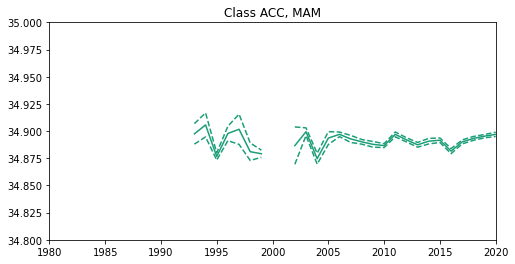

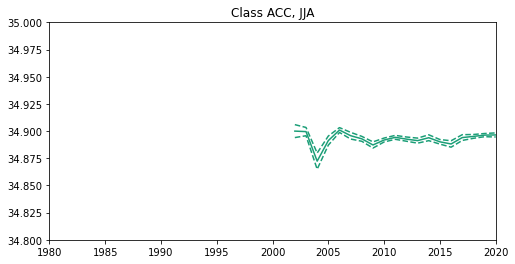

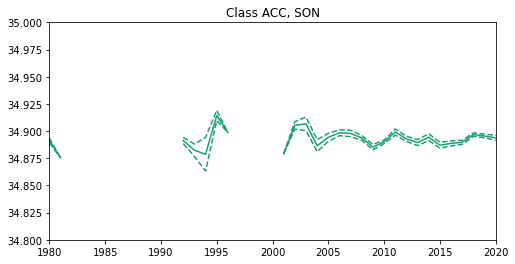

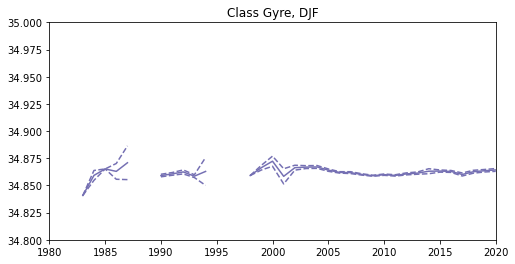

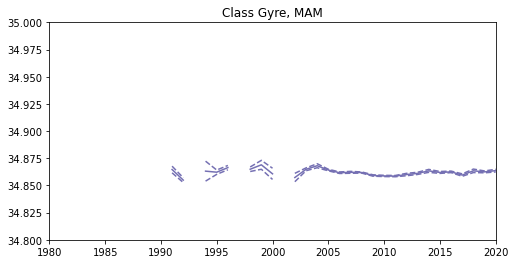

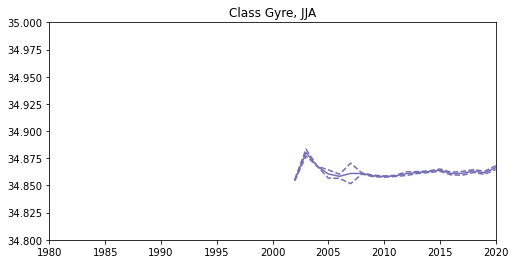

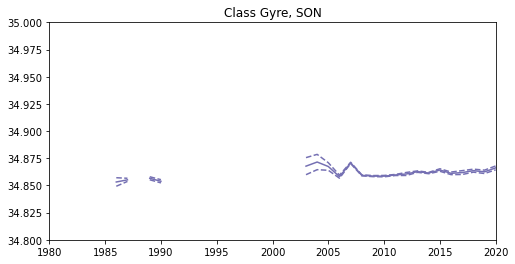

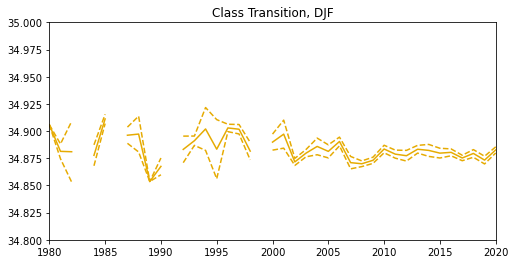

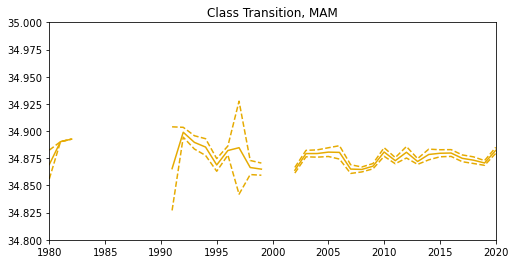

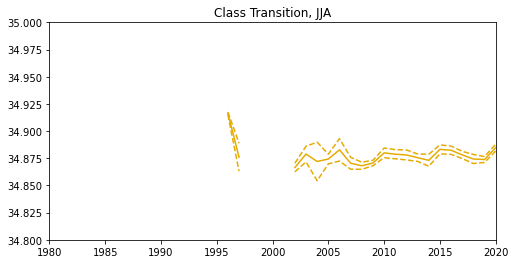

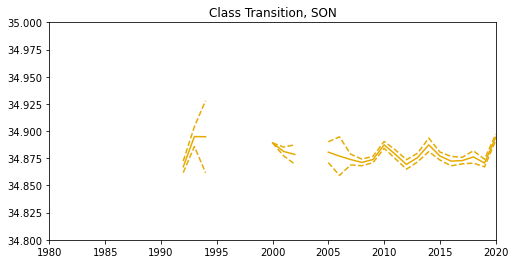

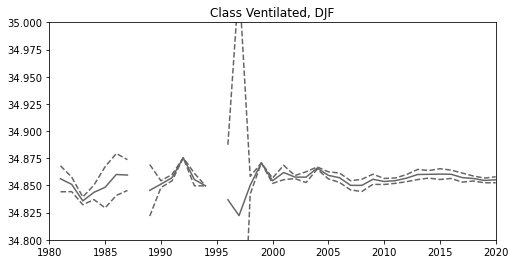

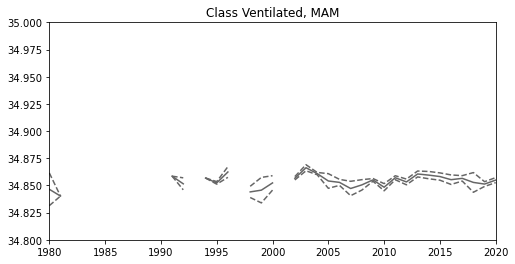

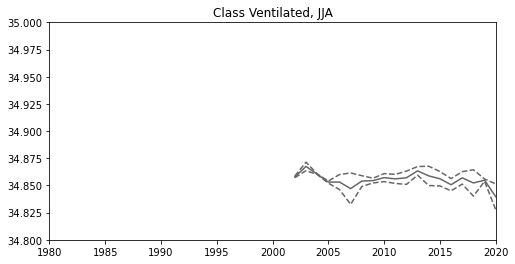

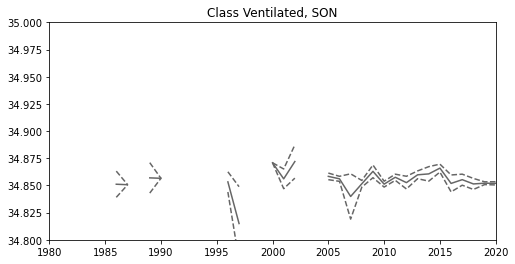

In [20]:
Smax_mean, Smax_std, Smax_N = at.calculate_stats_over_time(dfp, varName='Smax')
pt.plot_stats_from_analysis(ploc, dfp, Smax_mean, Smax_std, Smax_N, colormap, n_components_selected, varName='Smax', xlim=[1980, 2020], ylim=[34.8, 35.0])

### Smin

analysis.calculate_stats_over_time


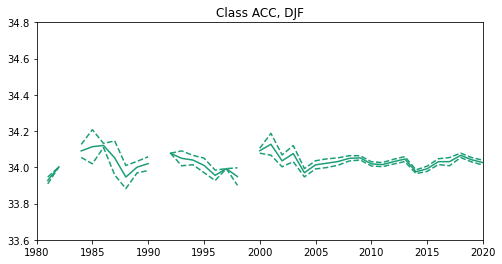

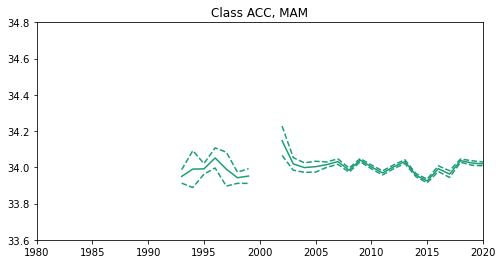

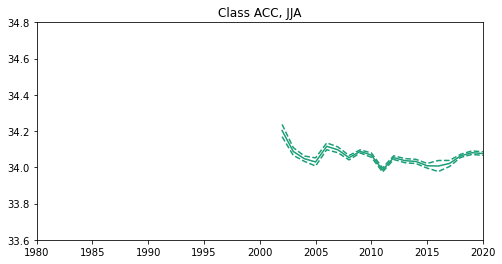

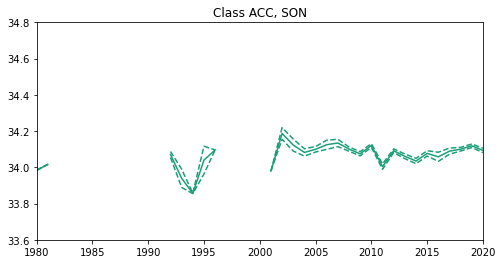

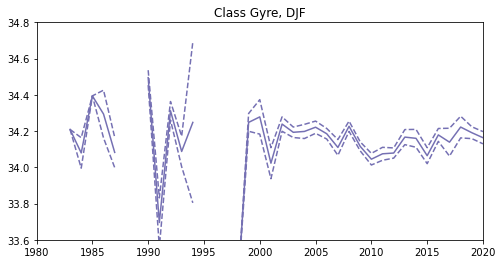

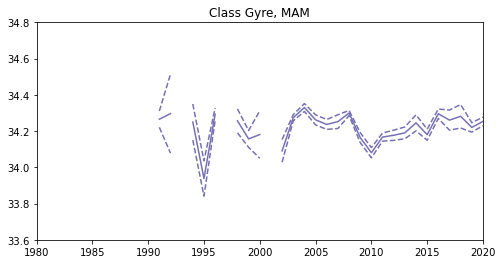

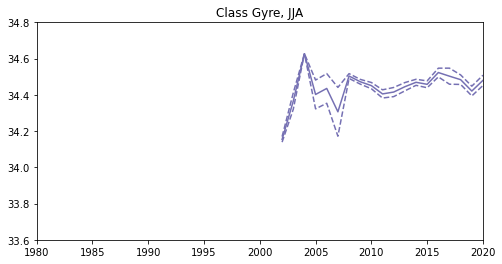

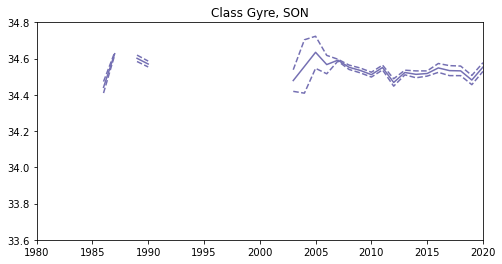

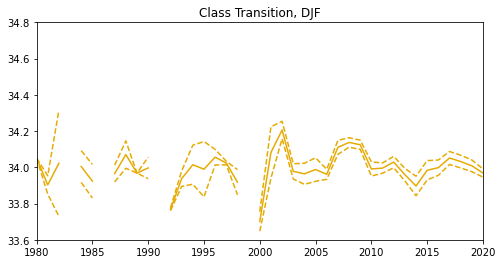

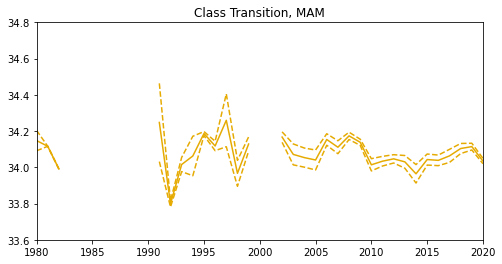

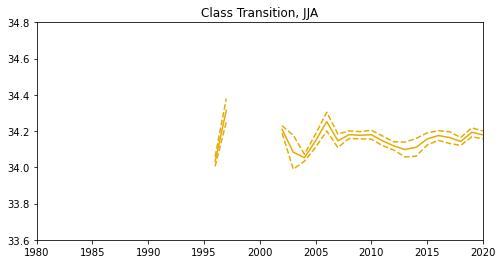

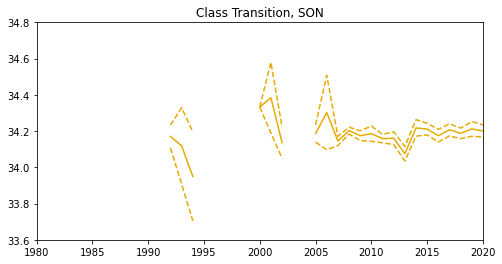

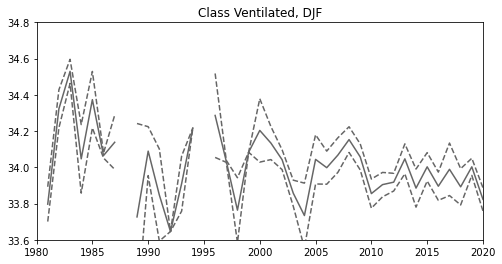

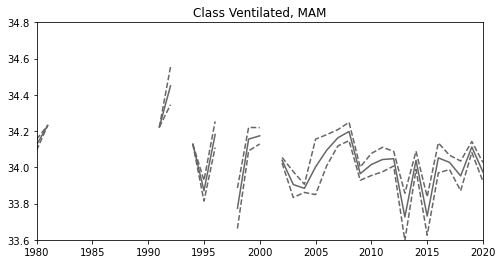

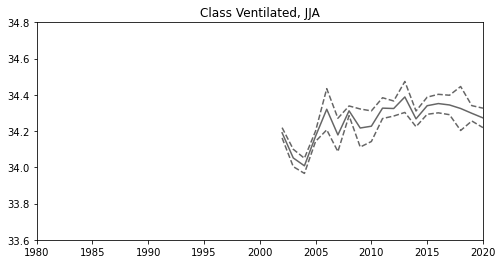

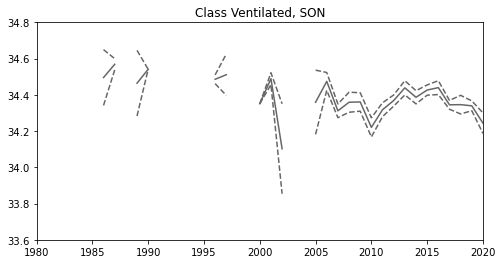

In [21]:
Smin_mean, Smin_std, Smin_N = at.calculate_stats_over_time(dfp, varName='Smin')
pt.plot_stats_from_analysis(ploc, dfp, Smin_mean, Smin_std, Smin_N, colormap, n_components_selected, varName='Smin', xlim=[1980,2020], ylim=[33.6, 34.8])

### MLD

analysis.calculate_stats_over_time


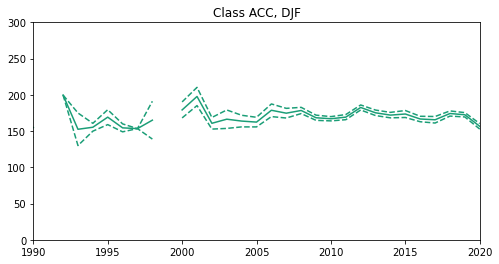

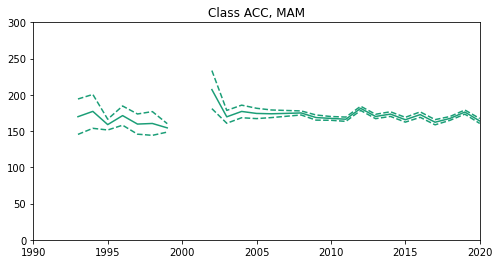

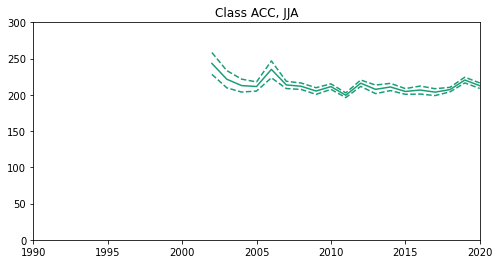

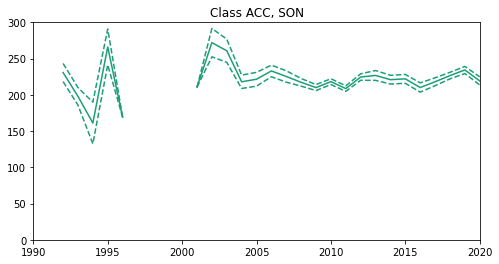

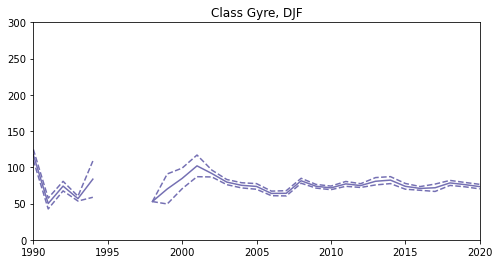

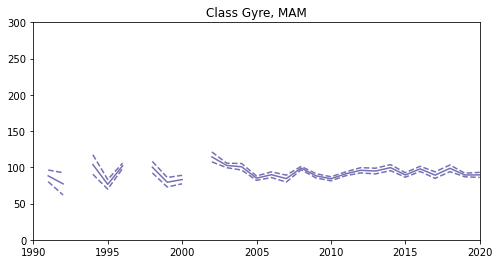

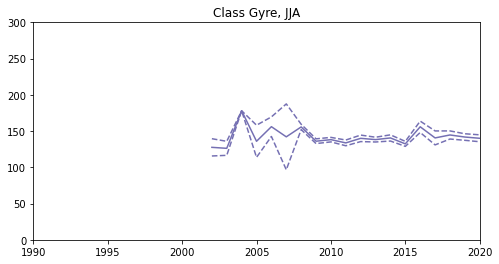

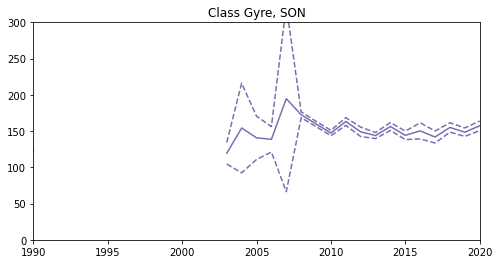

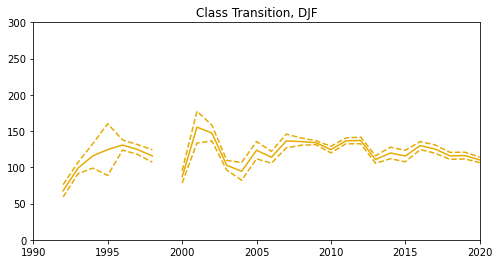

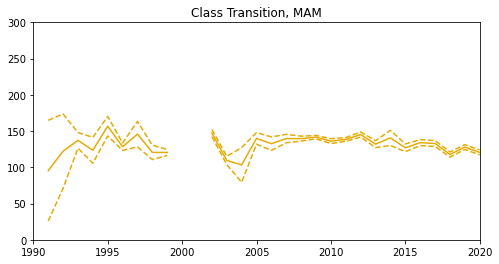

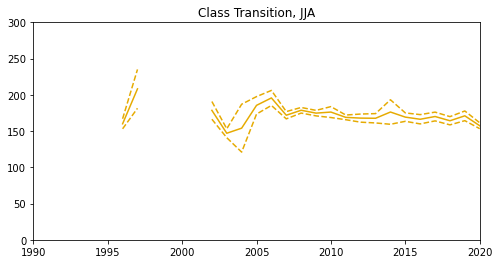

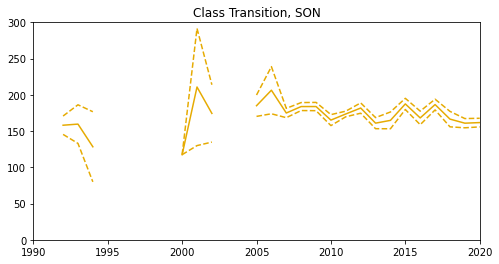

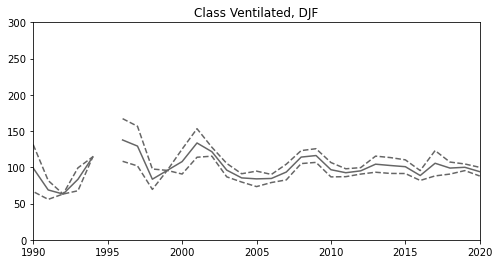

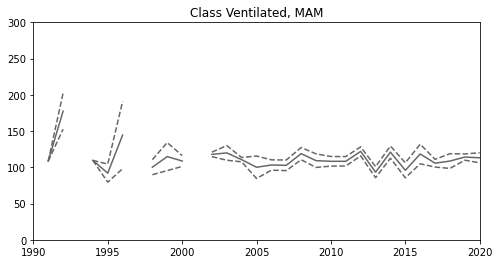

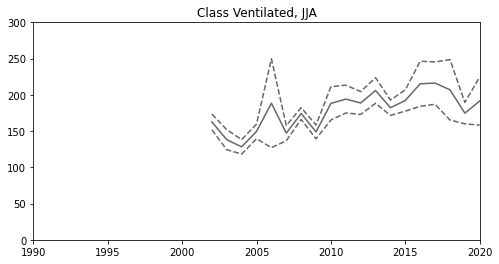

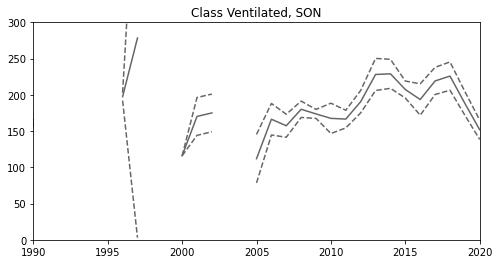

In [22]:
mld_mean, mld_std, mld_N = at.calculate_stats_over_time(dfp, varName='mld')
pt.plot_stats_from_analysis(ploc, dfp, mld_mean, mld_std, mld_N, colormap, n_components_selected, varName='mld', xlim=[1990,2020], ylim=[0,300])

### Near-surface stratification

analysis.calculate_stats_over_time


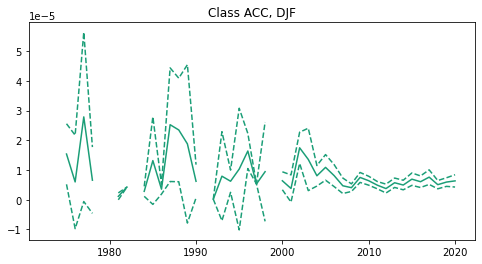

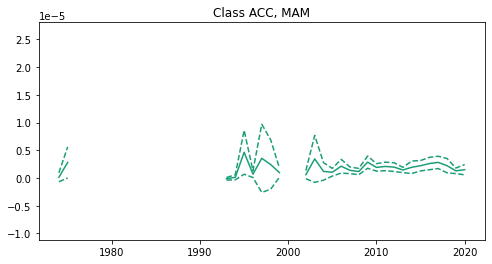

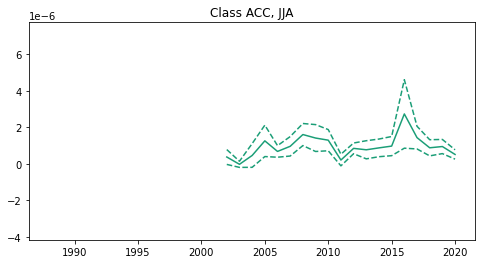

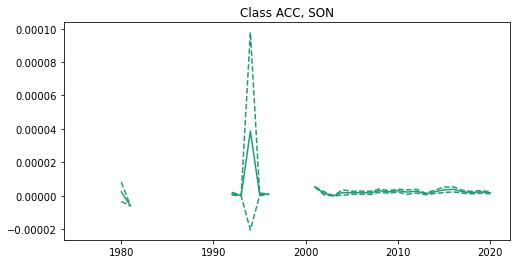

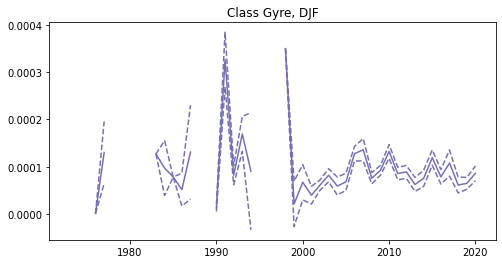

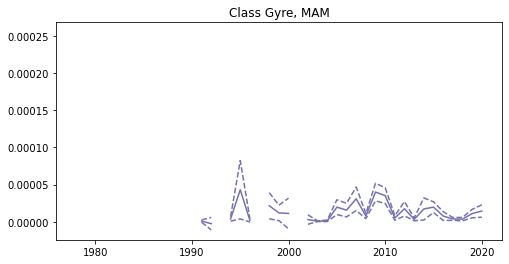

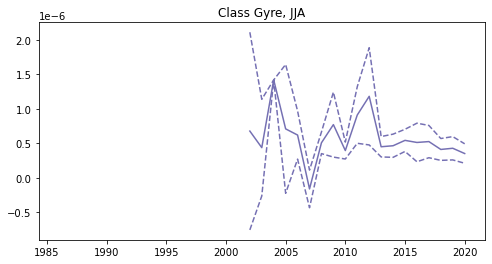

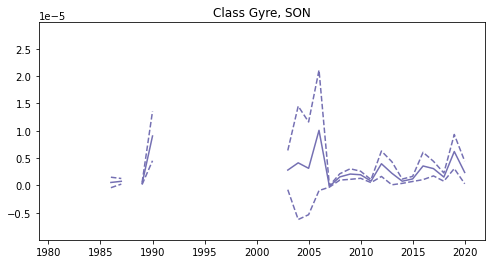

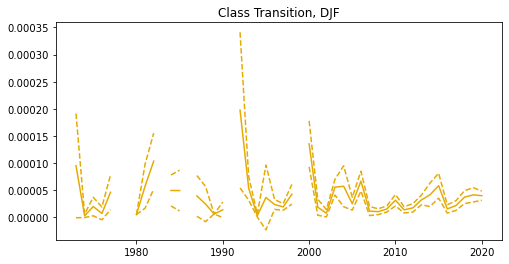

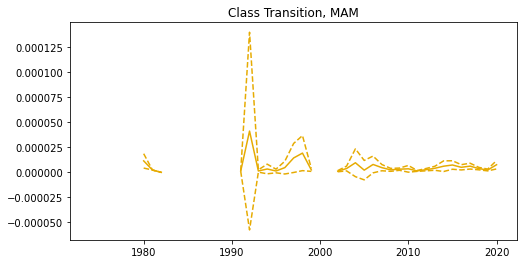

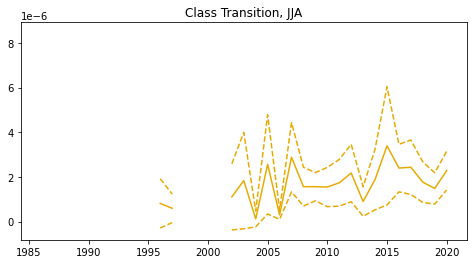

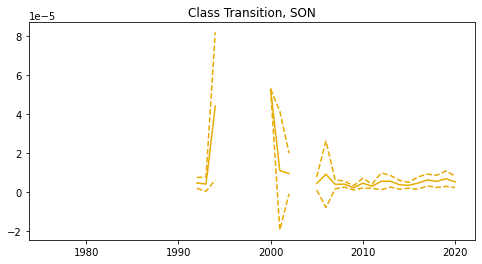

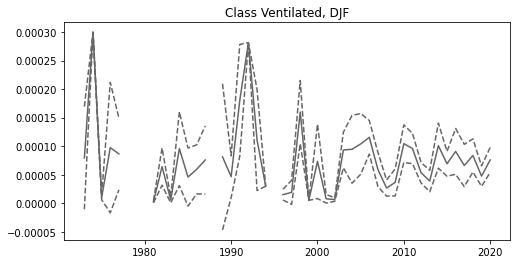

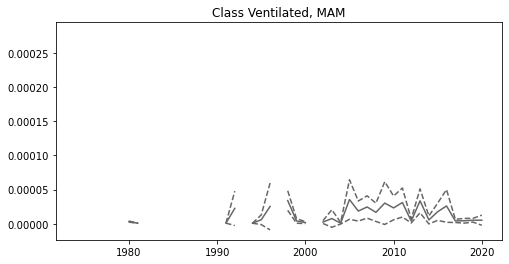

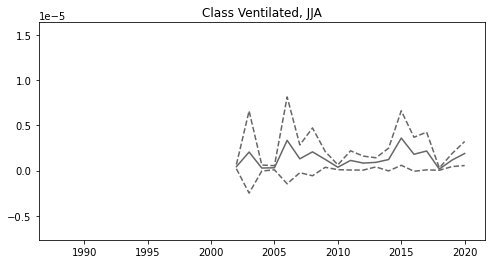

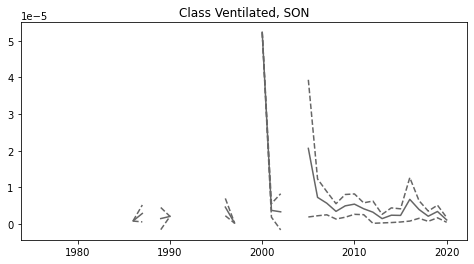

In [23]:
N2_mean, N2_std, N2_N = at.calculate_stats_over_time(dfp, varName='Nsquared_surface')
pt.plot_stats_from_analysis(ploc, dfp, N2_mean, N2_std, N2_N, colormap, n_components_selected, varName='Nsquared_surface')

### Depth of temperature maximum

analysis.calculate_stats_over_time


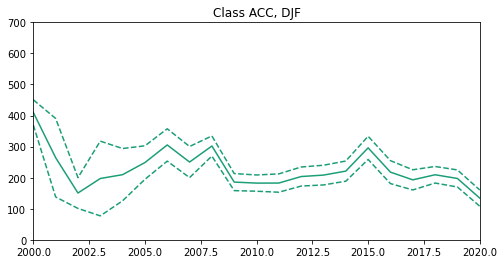

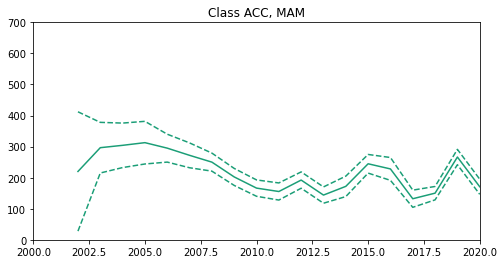

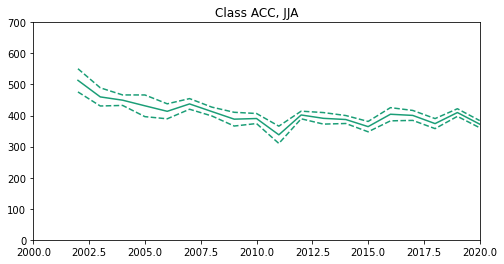

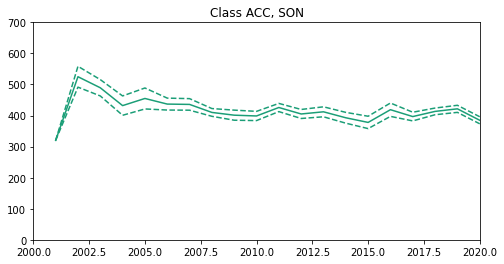

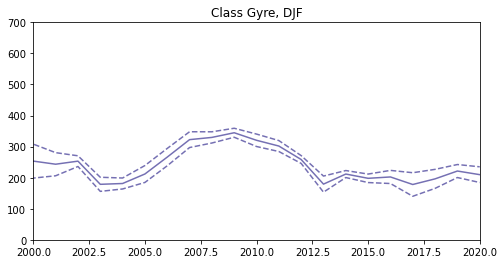

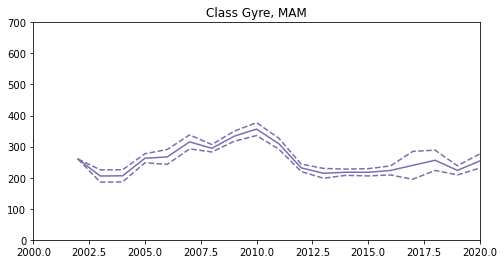

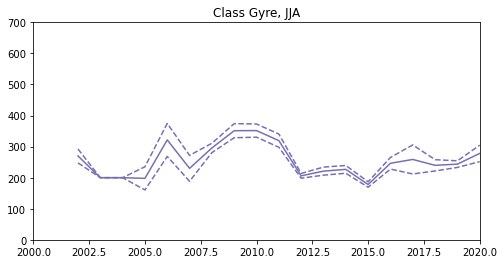

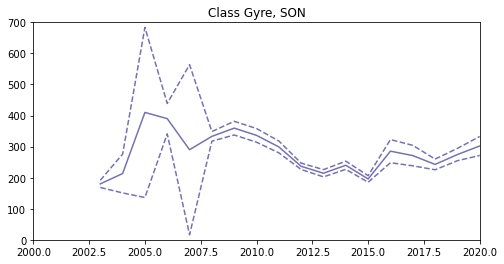

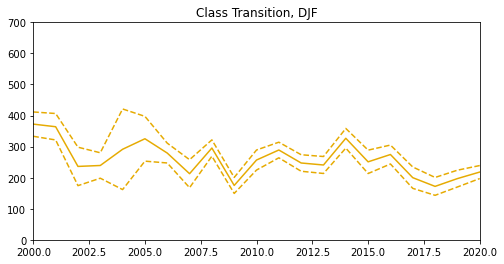

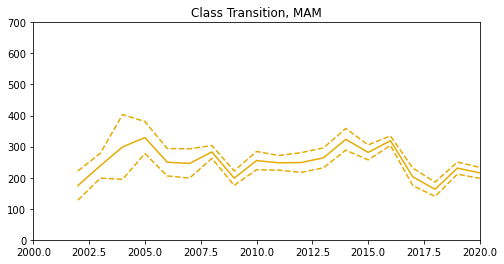

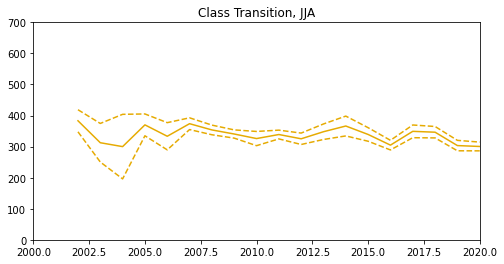

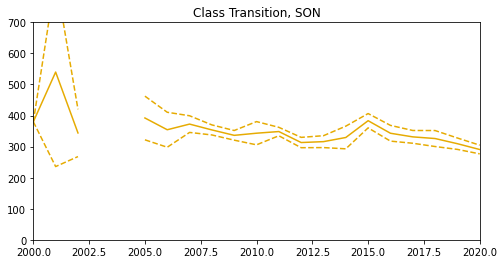

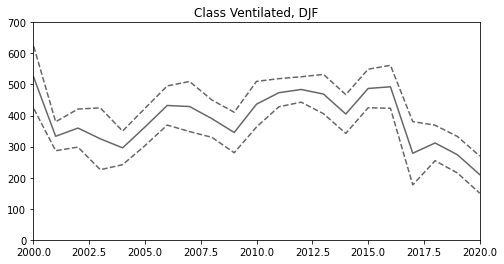

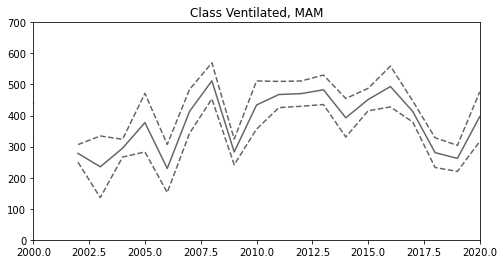

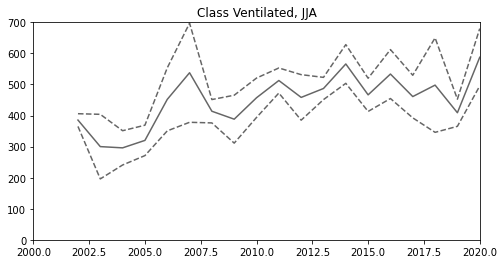

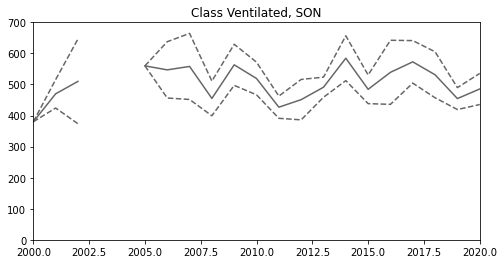

In [24]:
Tmaxd_mean, Tmaxd_std, Tmaxd_N = at.calculate_stats_over_time(dfp, varName='Tmax_depth')
pt.plot_stats_from_analysis(ploc, dfp, Tmaxd_mean, Tmaxd_std, Tmaxd_N, colormap, n_components_selected, varName='Tmax_depth', xlim=[2000, 2020], ylim=[0,700])

### Depth of temperature minimum

analysis.calculate_stats_over_time


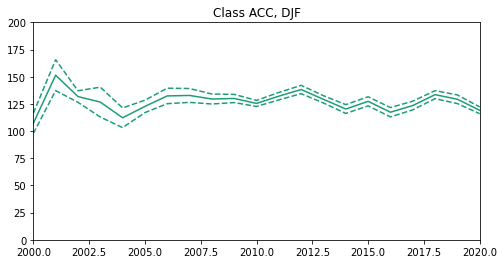

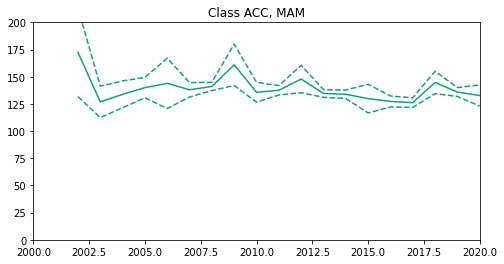

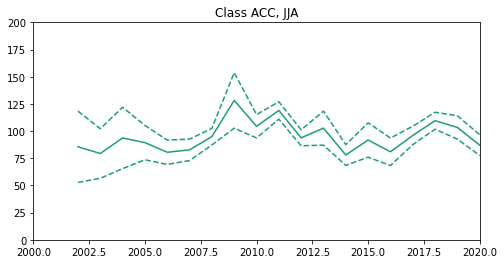

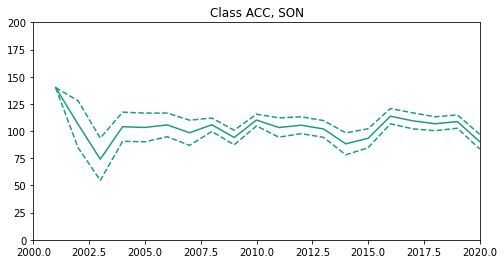

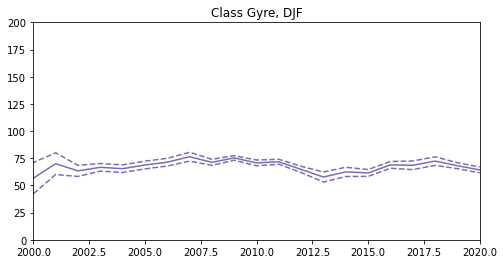

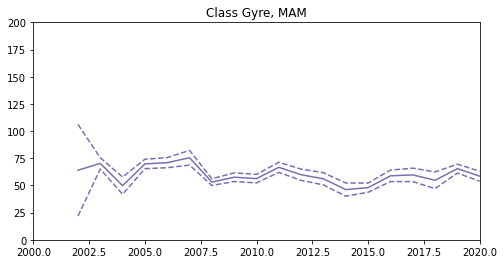

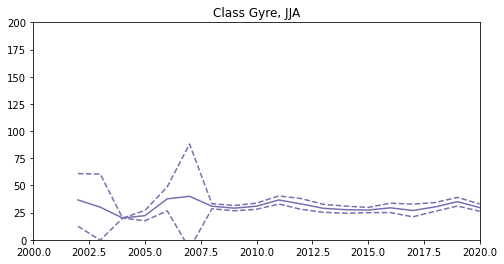

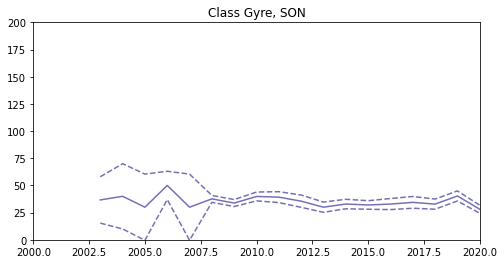

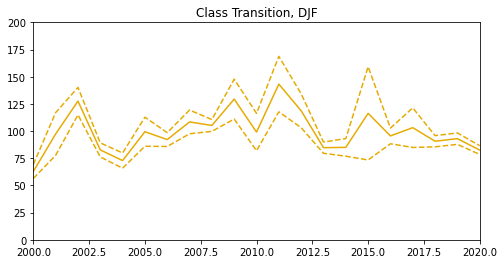

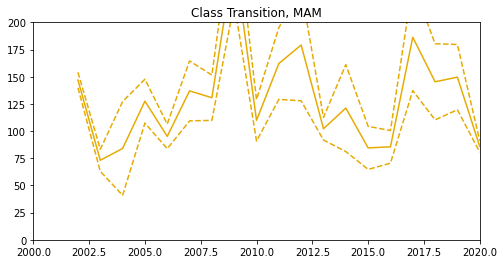

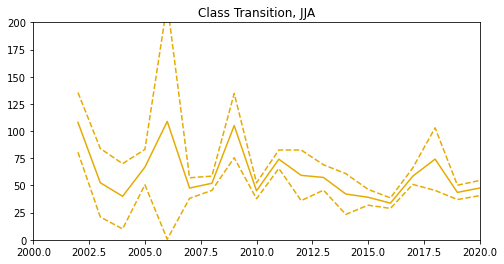

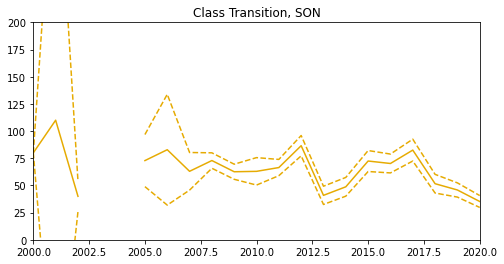

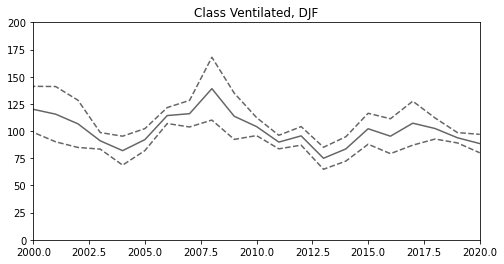

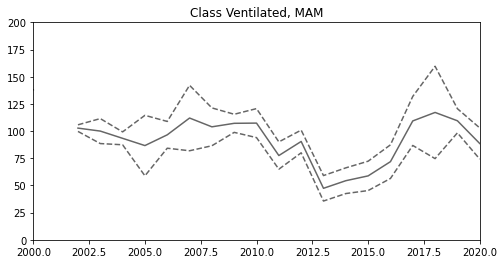

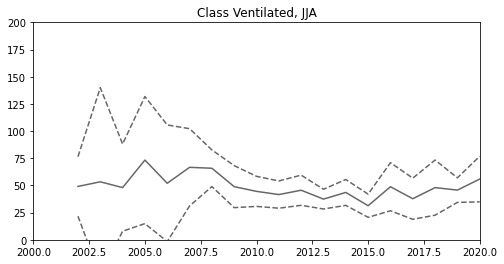

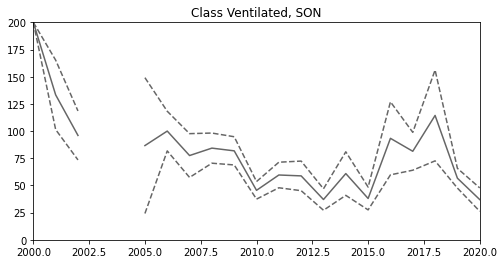

In [25]:
Tmind_mean, Tmind_std, Tmind_N = at.calculate_stats_over_time(dfp, varName='Tmin_depth')
pt.plot_stats_from_analysis(ploc, dfp, Tmind_mean, Tmind_std, Tmind_N, colormap, n_components_selected, varName='Tmin_depth', xlim=[2000, 2020], ylim=[0, 200])

### Linear regression of selected time series

In [26]:
dfp

<xarray.Dataset>
Dimensions:        (profile: 28397, depth: 21, CLASS: 4, depth_mid: 20)
Coordinates:
  * profile        (profile) int64 13 14 15 16 ... 142282 142301 142320 142330
    lon            (profile) float64 -26.44 -22.37 -17.38 ... 53.09 53.33 53.76
    lat            (profile) float64 -55.98 -56.81 -57.51 ... -58.46 -58.59
  * depth          (depth) float64 20.0 40.0 60.0 80.0 ... 820.0 910.0 1e+03
    time           (profile) datetime64[ns] 1973-01-11T12:00:00 ... 2020-10-1...
    year           (profile) int64 1973 1973 1973 1973 ... 2020 2020 2020 2020
    month          (profile) int64 1 1 1 1 1 1 1 1 1 1 ... 8 8 8 9 9 9 9 9 10 10
  * CLASS          (CLASS) int64 0 1 2 3
  * depth_mid      (depth_mid) float64 30.0 50.0 70.0 90.0 ... 775.0 865.0 955.0
    season         (profile) int64 1 1 1 1 1 1 1 1 1 1 1 ... 3 3 3 4 4 4 4 4 4 4
Data variables: (12/22)
    prof_date      (profile) float64 7.206e+05 7.206e+05 ... 7.381e+05 7.381e+05
    prof_YYYYMMDD  (profile) float64 1.973e+07 1.973e+07 ... 2.02e+07 2.02e+07
    prof_HHMMSS    (profile) float64 1.2e+05 1.2e+05 ... 4.45e+04 5.19e+04
    sig0           (profile, depth) float64 ...
    prof_SA        (profile, depth) float64 ...
    prof_CT        (profile, depth) float64 ...
    ...             ...
    Smin_depth     (profile) float64 20.0 20.0 20.0 20.0 ... 140.0 20.0 20.0
    Smax           (profile) float64 34.84 34.88 34.88 34.89 ... 34.9 34.9 34.9
    Smax_depth     (profile) float64 1e+03 730.0 910.0 ... 1e+03 1e+03 1e+03
    sig0min        (profile) float64 26.84 26.85 27.02 ... 27.32 27.29 27.27
    sig0max        (profile) float64 27.83 27.82 27.8 27.81 ... 27.8 27.8 27.8
    imetric        (profile) float64 0.005076 0.004052 0.5348 ... 0.2883 0.1321

In [27]:
ploc

'plots/plots_WeddellClassOnly_top1000m_K04_forPaper/'